# Модель  предсказания снижения покупательской активности
**Описание исследования:** заказчик исследования - интернет-магазин «В один клик». Магазин продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель исследования:** разработать модель, которая предскажет вероятность снижения покупательской активности, а также выделить сегмент покупателей, проанализировать его и дать предложения по увеличитению покупательской активности.

**Исходные данные:** 
1. Датасет **market_file**  содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Описание данных:
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


2. Датасет **market_money** содержит данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Описание данных:
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.


3. Датасет **market_time** — содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода. Описание данных:
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

4. Датасет **money** - содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

Ислледование состоит из следущих этапов:
1. Загрузка и изучение исходных данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Объединение таблиц.
5. Корреляционный анализ. 
6. Использование пайплайнов.
7. Анализ важности признаков.
8. Сегментация покупателей.
9. Общий вывод.

## Загрузка данных

#### Импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score

Устанавливаем библиотеки phik и shap и обновляем scikit-learn. Во всяком случае, для меня требовалось делать это при каждом новом открытии тетрадки, а также **перезагружать ядро**.

In [2]:
!pip install phik
!pip install shap
!pip install scikit-learn --upgrade
import shap
from phik import phik_matrix

#### Загрузка исходных данных

Считываем данные из исходных файлов:

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep = ';')

Выведем общую информацию о датафреймах и их первые записи:

In [4]:
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [7]:
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


#### Изменение названий столбцов

Переименуем столбцы датафреймов, чтобы они соответствовали стандартам оформления данных:

In [8]:
for dataframe in [market_file, market_money, market_time, money]:
    columns_dict = {}
    for column in dataframe.columns:
        columns_dict[column] = column.lower().replace(' ', '_')
    dataframe = dataframe.rename(columns = columns_dict, inplace = True)

Выведем новые названия столбцов на экран:

In [9]:
print('Названия столбцов датафрейма market_file:', market_file.columns)
print('Названия столбцов датафрейма market_money:', market_money.columns)
print('Названия столбцов датафрейма market_time:', market_time.columns)
print('Названия столбцов датафрейма money:', money.columns)

Названия столбцов датафрейма market_file: Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Названия столбцов датафрейма market_money: Index(['id', 'период', 'выручка'], dtype='object')
Названия столбцов датафрейма market_time: Index(['id', 'период', 'минут'], dtype='object')
Названия столбцов датафрейма money: Index(['id', 'прибыль'], dtype='object')


#### Выводу по первому этапу 
- импортированы необходимые для работы библиотеки;  
- прочитаны и загружены в датафреймы файлы с исходными данными;  
- получена общая информация о данных (столбцы, типы данных);  
- переименованы столбцы датафреймов для приведения названий к стандартам оформления данных.

## Предобработка данных

#### Изменение типов данных

В датафрейме money количественный признак 'прибыль' имеет строковый тип данных. Исправим это:

In [10]:
money['прибыль'] = money['прибыль'].str.replace(',', '.').astype(float)

Убедимся, что преобразование прошло успешно:

In [11]:
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Теперь столбцы имеют корректные типы данных.

По результатам вызовов метода .info() в каждом датафрейме видно, что пропусков в данных нет. Тогда перейдем сразу к обработке дубликатов.

#### Обработка дубликатов

Проверим данные на наличие неявных дубликатов:

In [12]:
for column in market_file.select_dtypes(include = "object"):
    print(f"Уникальные значения в столбце {str(column)}:")
    print(market_file[column].sort_values().unique(), "\n")

Уникальные значения в столбце покупательская_активность:
['Прежний уровень' 'Снизилась'] 

Уникальные значения в столбце тип_сервиса:
['премиум' 'стандарт' 'стандартт'] 

Уникальные значения в столбце разрешить_сообщать:
['да' 'нет'] 

Уникальные значения в столбце популярная_категория:
['Домашний текстиль' 'Косметика и аксесуары' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника' 'Техника для красоты и здоровья'
 'Товары для детей'] 



In [13]:
for column in market_money.select_dtypes(include = "object"):
    print(f"Уникальные значения в столбце {str(column)}:")
    print(market_money[column].sort_values().unique(), "\n")

Уникальные значения в столбце период:
['предыдущий_месяц' 'препредыдущий_месяц' 'текущий_месяц'] 



In [14]:
market_time
for column in market_time.select_dtypes(include = "object"):
    print(f"Уникальные значения в столбце {str(column)}:")
    print(market_time[column].sort_values().unique(), "\n")

Уникальные значения в столбце период:
['предыдцщий_месяц' 'текущий_месяц'] 



В датафрейме market_file обнаружены неявные дубликаты. Избавимся от них:

In [15]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace({'стандартт': 'стандарт'})

Также приведем значения в столбце 'период' датафрейма market_time в соответствие с аналогичными значениями в датафрейме market_money:

In [16]:
market_time['период'] = market_time['период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})

Проверим корректность изменений:

In [17]:
print('Уникальные значения в столбце тип_сервиса датафрейма market_file:')
print(market_file['тип_сервиса'].sort_values().unique(), "\n")

print('Уникальные значения в столбце период датафрейма market_money:')
print(market_money['период'].sort_values().unique(), "\n")

print('Уникальные значения в столбце период датафрейма market_time:')
print(market_time['период'].sort_values().unique(), "\n")

Уникальные значения в столбце тип_сервиса датафрейма market_file:
['премиум' 'стандарт'] 

Уникальные значения в столбце период датафрейма market_money:
['предыдущий_месяц' 'препредыдущий_месяц' 'текущий_месяц'] 

Уникальные значения в столбце период датафрейма market_time:
['предыдущий_месяц' 'текущий_месяц'] 



Изменения прошли успешно. Проверим данные на наличие явных дубликатов:

In [18]:
print(f'Явных дубликатов в market_file: {market_file.duplicated().sum()}')
print(f'Явных дубликатов в market_money: {market_money.duplicated().sum()}')
print(f'Явных дубликатов в market_time: {market_time.duplicated().sum()}')
print(f'Явных дубликатов в money: {money.duplicated().sum()}')

Явных дубликатов в market_file: 0
Явных дубликатов в market_money: 0
Явных дубликатов в market_time: 0
Явных дубликатов в money: 0


Дубликаты в данных отсутствуют.

#### Выводы по второму этапу 
- изучены типы данных столбцов; преобразован тип данных столбца 'прибыль' датафрейма money;      
- проведена проверка наличия пропусков в данных, пропуски не обнаружены;   
- в датафреймах market_file обнаружены и устранены неявные дубликаты;
- проведена проверка наличия явных дубликатов, явные дубликаты в данных отсутствуют.

## Исследовательский анализ данных

Проведем исследовательский анализ исходных данных

#### Исследовательский анализ market_file

Рассмотрим распределение данных о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Вспомним структуру данных:

In [19]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Рассмотрим распределение класса покупательской активности пользователей - целевого признака исследования:

In [20]:
market_file['покупательская_активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

Доля сохраненной покупательской активности: 0.62
Доля снизившейся покупательской активности: 0.38


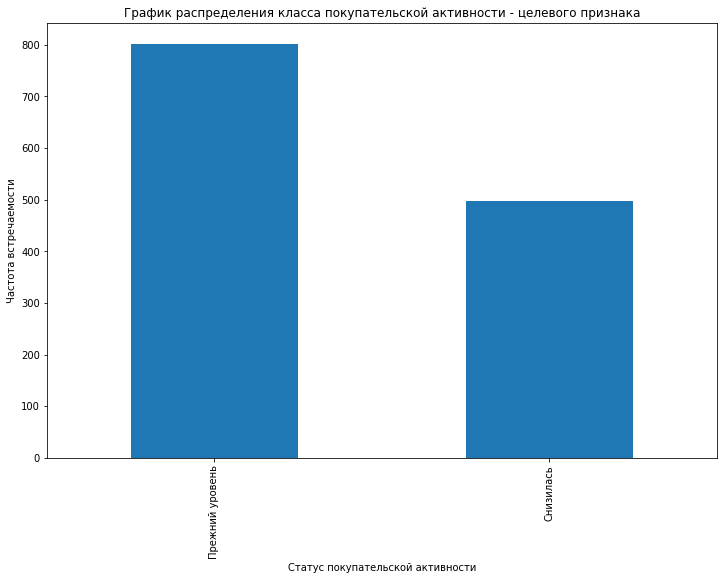

In [21]:
ax = market_file['покупательская_активность'].value_counts().plot(kind = 'bar', figsize = (12, 8))
ax.set_xlabel('Статус покупательской активности');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения класса покупательской активности - целевого признака");
print(f'Доля сохраненной покупательской активности: \
{market_file["покупательская_активность"].value_counts()["Прежний уровень"] / market_file.shape[0]:.2f}')
print(f'Доля снизившейся покупательской активности: \
{market_file["покупательская_активность"].value_counts()["Снизилась"] / market_file.shape[0]:.2f}')

В данном признаке наблюдается легкий дисбаланс классов: снижение покупательской активности произошло у меньшего количество клиентов, чем ее сохранение на прежнем уровне. Вследствие этого при разбиении данных на выборки будем использовать стратификацию.

Рассмотрим распределение уровеня сервиса пользователей:

In [22]:
market_file['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

Доля клиентов стандартного уровня сервиса: 0.71
Доля клиентов премиум сервиса: 0.29


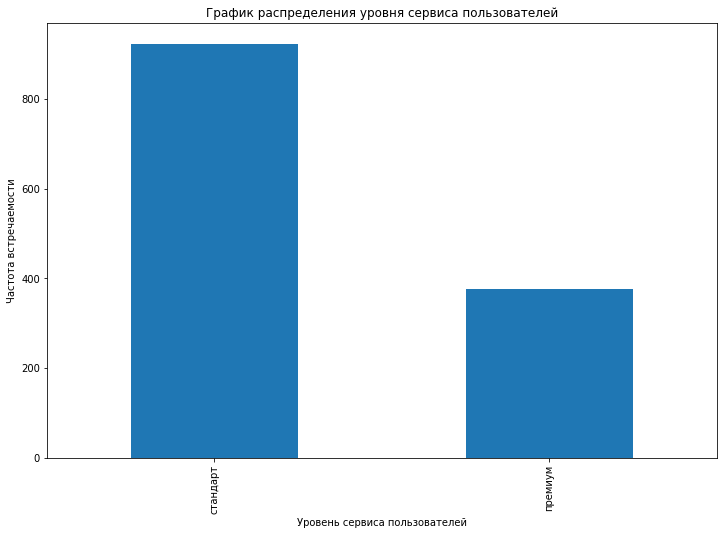

In [23]:
ax = market_file['тип_сервиса'].value_counts().plot(kind = 'bar', figsize = (12, 8))
ax.set_xlabel('Уровень сервиса пользователей');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения уровня сервиса пользователей");
print(f'Доля клиентов стандартного уровня сервиса: \
{market_file["тип_сервиса"].value_counts()["стандарт"] / market_file.shape[0]:.2f}')
print(f'Доля клиентов премиум сервиса: \
{market_file["тип_сервиса"].value_counts()["премиум"] / market_file.shape[0]:.2f}')

Большинство клиентов имеют стандартный уровень сервиса, доля премиум сегмента составляет 29%.

Рассмотрим распределение согласия покупателей на рассылки про дополнительные предложения о товаре:

In [24]:
market_file['разрешить_сообщать'].value_counts()

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

Дали согласие: 0.74
Не дали согласие: 0.26


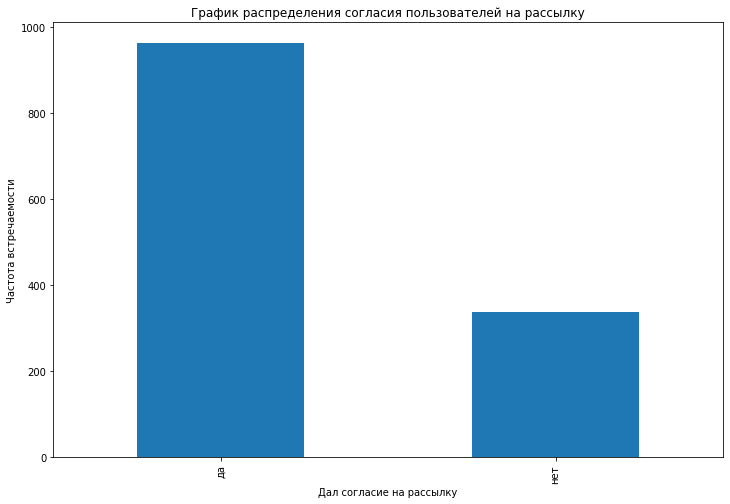

In [25]:
ax = market_file['разрешить_сообщать'].value_counts().plot(kind = 'bar', figsize = (12, 8))
ax.set_xlabel('Дал согласие на рассылку');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения согласия пользователей на рассылку");
print(f'Дали согласие: \
{market_file["разрешить_сообщать"].value_counts()["да"] / market_file.shape[0]:.2f}')
print(f'Не дали согласие: \
{market_file["разрешить_сообщать"].value_counts()["нет"] / market_file.shape[0]:.2f}')

Большинство клиентов дали согласие на рассылку про дополнительные предложения о товарах, доля отказавшихся составляет 26%.

Рассмотрим распределение среднемесячного значения маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев:

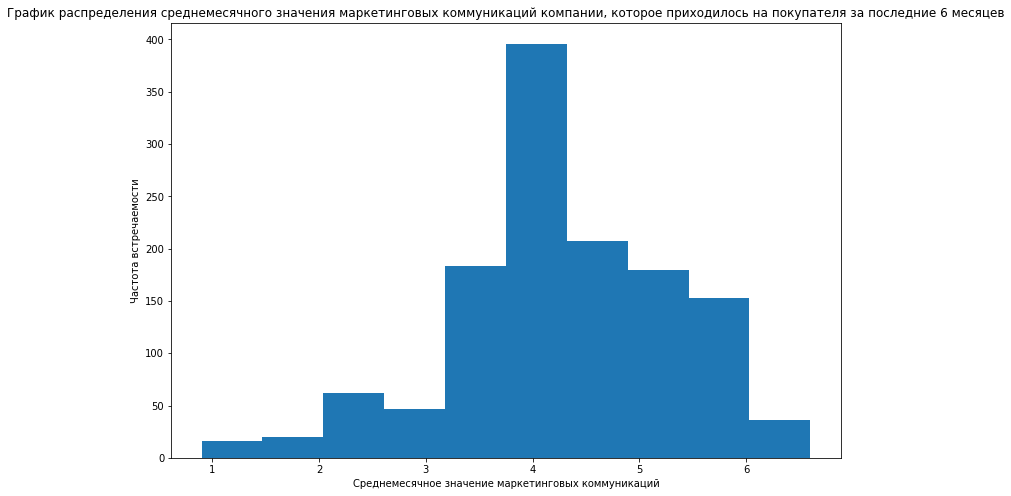

In [26]:
ax = market_file['маркет_актив_6_мес'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Среднемесячное значение маркетинговых коммуникаций');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднемесячного значения маркетинговых коммуникаций компании, \
которое приходилось на покупателя за последние 6 месяцев");

Рассмотрим среднее и медианные значения:

In [27]:
print(f'Среднее значение маркетинговых коммуникаций за 6 месяцев: { market_file["маркет_актив_6_мес"].mean():.2f}')
print(f'Медианное значение маркетинговых коммуникаций за 6 месяцев: { market_file["маркет_актив_6_мес"].median():.2f}')

Среднее значение маркетинговых коммуникаций за 6 месяцев: 4.25
Медианное значение маркетинговых коммуникаций за 6 месяцев: 4.20


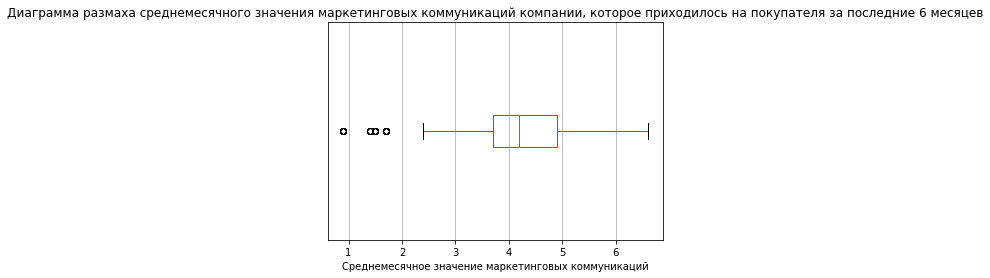

In [28]:
ax = market_file['маркет_актив_6_мес'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Среднемесячное значение маркетинговых коммуникаций")
ax.set_title("Диаграмма размаха среднемесячного значения маркетинговых коммуникаций компании, \
которое приходилось на покупателя за последние 6 месяцев");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

Для большинства клиентов характерно среднемесячное значение маркетинговых коммуникаций от 3.7 до 5.

Рассмотрим распределение количества маркетинговых коммуникаций в текущем месяце:

In [29]:
market_file['маркет_актив_тек_мес'].value_counts()

4    669
5    323
3    308
Name: маркет_актив_тек_мес, dtype: int64

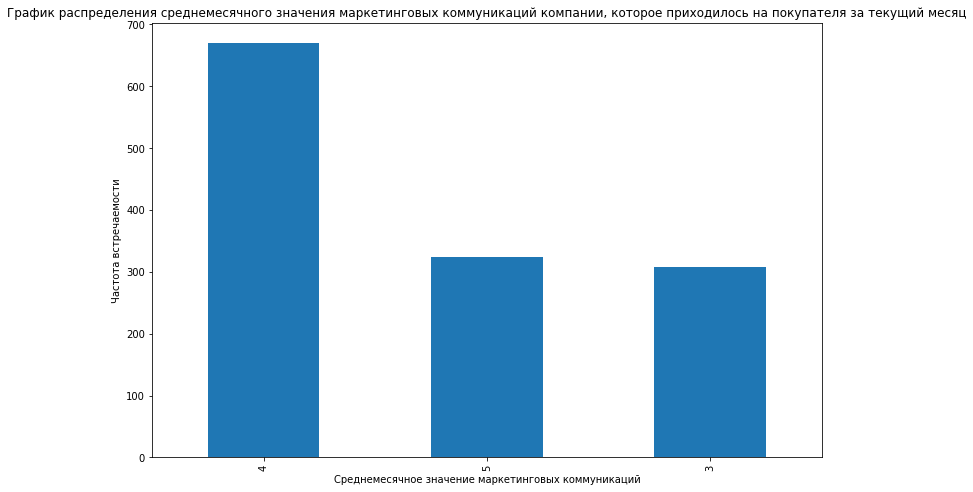

In [30]:
ax = market_file['маркет_актив_тек_мес'].value_counts().plot(kind = 'bar', figsize = (12, 8))
ax.set_xlabel('Среднемесячное значение маркетинговых коммуникаций');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднемесячного значения маркетинговых коммуникаций компании, \
которое приходилось на покупателя за текущий месяц");

Для болшинства клиентов характерным значением маркетинговых коммуникаций за текущий месяц является 4. Кроме этого, одинаково часто встречаются значения 3 и 5.

Рассмотрим распределение количества дней с момента регистрации покупателя на сайте:

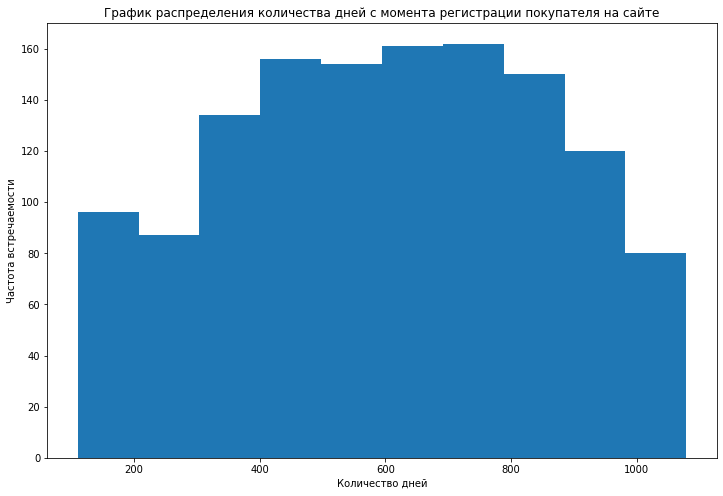

In [31]:
ax = market_file['длительность'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Количество дней');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения количества дней с момента регистрации покупателя на сайте");

Расммотрим средниее и медианное значения количества дней с момента регистрации покупателя:

In [32]:
print(f'Среднее значение количества дней с момента регистрации: {market_file["длительность"].mean():.2f}')
print(f'Медианное значение количества дней с момента регистрации: {market_file["длительность"].median():.2f}')

Среднее значение количества дней с момента регистрации: 601.90
Медианное значение количества дней с момента регистрации: 606.00


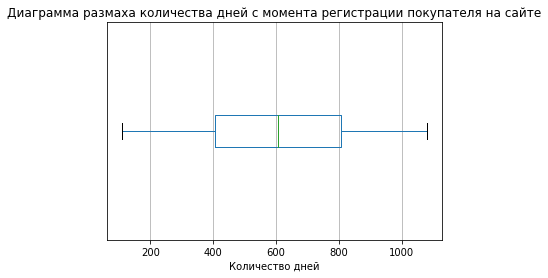

In [33]:
ax = market_file['длительность'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Количество дней")
ax.set_title("Диаграмма размаха количества дней с момента регистрации покупателя на сайте");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

В среднем пользователи зарегистрированы на сайте уже в течение 606 дней. Для большинства характерна длительность регистрации от 400 до 800 дней.

Рассмотрим распределение среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев:

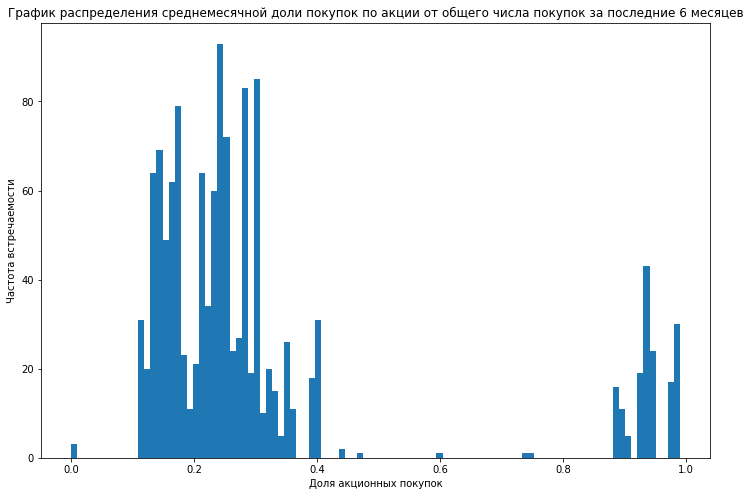

In [34]:
ax = market_file['акционные_покупки'].plot(kind = 'hist', bins = 100,figsize = (12, 8))
ax.set_xlabel('Доля акционных покупок');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев");

Рассмотрим среднее и медианное значение доли покупок по акции от общего числа покупок за последние 6 месяцев:

In [35]:
print(f'Среднее значение доли покупок по акции от общего числа покупок за последние 6 месяцев: \
{market_file["акционные_покупки"].mean():.2f}')
print(f'Медианное значение доли покупок по акции от общего числа покупок за последние 6 месяцев: \
{market_file["акционные_покупки"].median():.2f}')

Среднее значение доли покупок по акции от общего числа покупок за последние 6 месяцев: 0.32
Медианное значение доли покупок по акции от общего числа покупок за последние 6 месяцев: 0.24


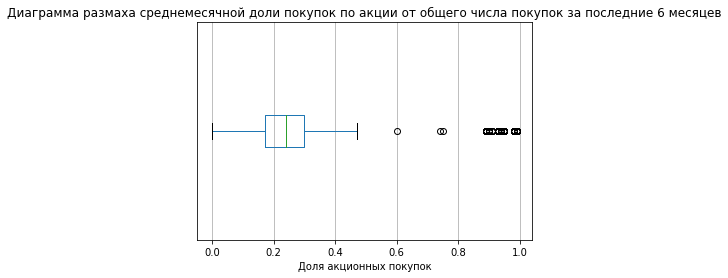

In [36]:
ax = market_file['акционные_покупки'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Доля акционных покупок")
ax.set_title("Диаграмма размаха среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

Данные распределены неоднородно. Наблюдаются пики в районе 0.18, 0.25 и 0.95. Данные признак преобразуем в категориальный: доле покупок по скидкам до 0.2 поставим в соответсвие "низкая", до 0.6 - "средняя", остальным - "высокая". Сделаем это  с помощью вспомогательной функции:

In [37]:
def get_discount_label(row):
    discount = row['акционные_покупки']
    if discount < 0.2:
        return 'низкая'
    elif discount < 0.6:
        return 'средняя'
    else:
        return 'высокая'

Добавим новый столбец:

In [38]:
market_file["акционные_покупки_категориальный"] = market_file.apply(get_discount_label, axis = 1)

Построим новый график:

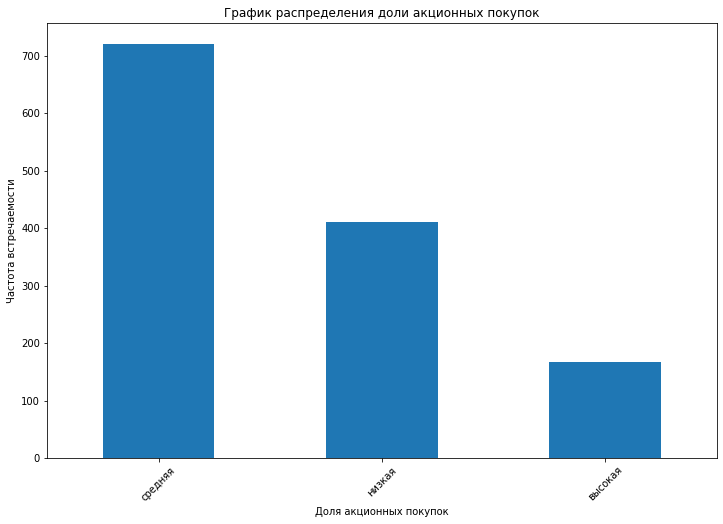

In [39]:
ax = market_file['акционные_покупки_категориальный'].value_counts().plot(kind = 'bar', figsize = (12, 8), rot = 45)
ax.set_xlabel('Доля акционных покупок');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения доли акционных покупок");

Болшинству клиентов соответсвует средняя доля покупаок по акции, много акционных товаров берет меньшее количество клиентов.

Рассмотрим значение популярной категории товаров у покупателя за последние 6 месяцев:

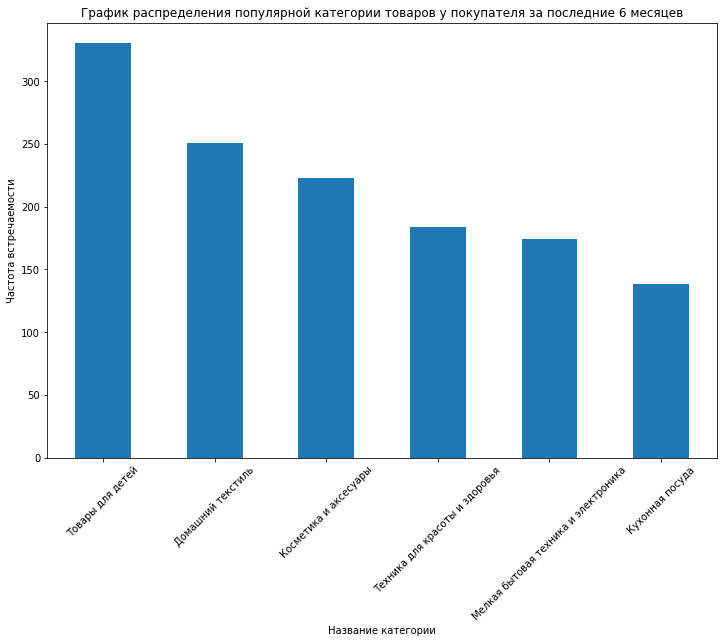

In [40]:
ax = market_file['популярная_категория'].value_counts().plot(kind = 'bar', figsize = (12, 8), rot = 45)
ax.set_xlabel('Название категории');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения популярной категории товаров у покупателя за последние 6 месяцев");

Самой популярной категорией является "Товары для детей", самой непопулярной - "Кухонная посуда".

Рассмотрим распределение среднего количества просмотренных покупателем категорий в течение одного визита за последний месяц:

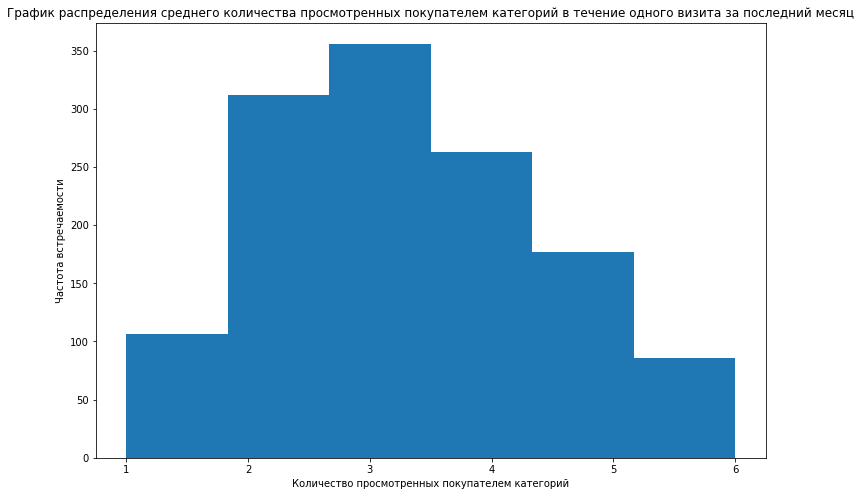

In [41]:
ax = market_file['средний_просмотр_категорий_за_визит'].plot(kind = 'hist', bins = 6, figsize = (12, 8))
ax.set_xlabel('Количество просмотренных покупателем категорий');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднего количества просмотренных покупателем категорий \
в течение одного визита за последний месяц");

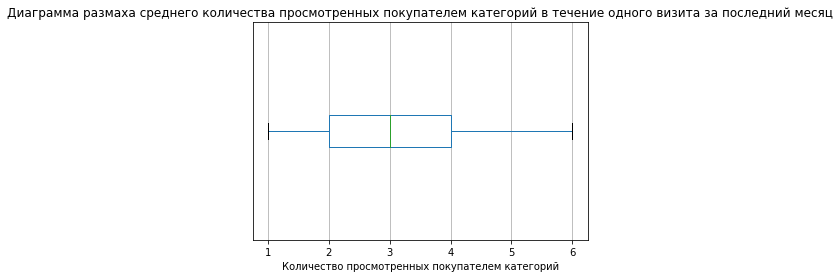

In [42]:
ax = market_file['средний_просмотр_категорий_за_визит'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Количество просмотренных покупателем категорий")
ax.set_title("Диаграмма размаха среднего количества просмотренных покупателем категорий \
в течение одного визита за последний месяц");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

Большинство покупателей за один визит на сайт просматривает от 2 до 4 категорий.

Рассмотрим распределение числа неоплаченных товаров в корзине покупателя за последние 3 месяца:

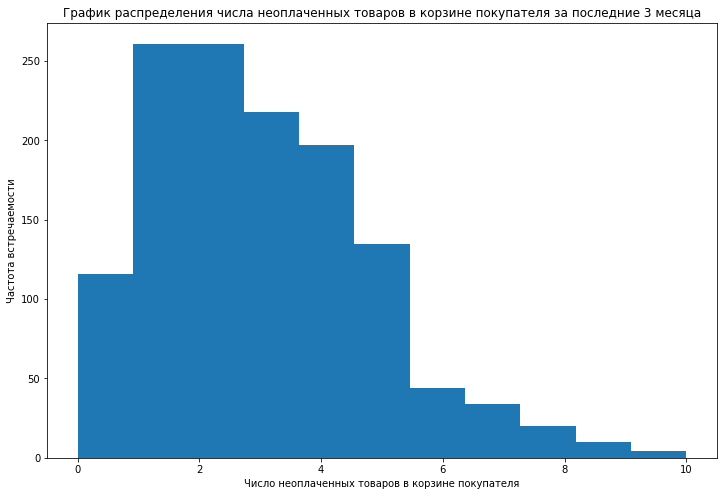

In [43]:
ax = market_file['неоплаченные_продукты_штук_квартал'].plot(kind = 'hist', bins = 11, figsize = (12, 8))
ax.set_xlabel('Число неоплаченных товаров в корзине покупателя');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения числа неоплаченных товаров в корзине покупателя за последние 3 месяца");

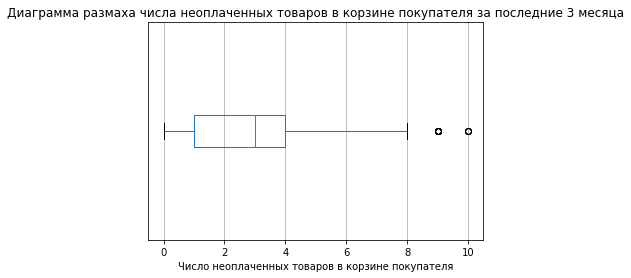

In [44]:
ax = market_file['неоплаченные_продукты_штук_квартал'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Число неоплаченных товаров в корзине покупателя")
ax.set_title("Диаграмма размаха числа неоплаченных товаров в корзине покупателя за последние 3 месяца");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

Рассмотрим среднее и медианное значения:

In [45]:
print(f'Среднее значение неоплаченных товаров в корзине покупателя за последние 3 месяца: \
{market_file["неоплаченные_продукты_штук_квартал"].mean():.2f}')
print(f'Медианное значение неоплаченных товаров в корзине покупателя за последние 3 месяца: \
{market_file["неоплаченные_продукты_штук_квартал"].median():.2f}')

Среднее значение неоплаченных товаров в корзине покупателя за последние 3 месяца: 2.84
Медианное значение неоплаченных товаров в корзине покупателя за последние 3 месяца: 3.00


В среднем в корзине пользователей находится около 3 неоплаченных товаров. Для большинства пользователей характерно значение от 1 до 4 штук.

Рассмотрим распределение числа сбоев, которые коснулись покупателя во время посещения сайта:

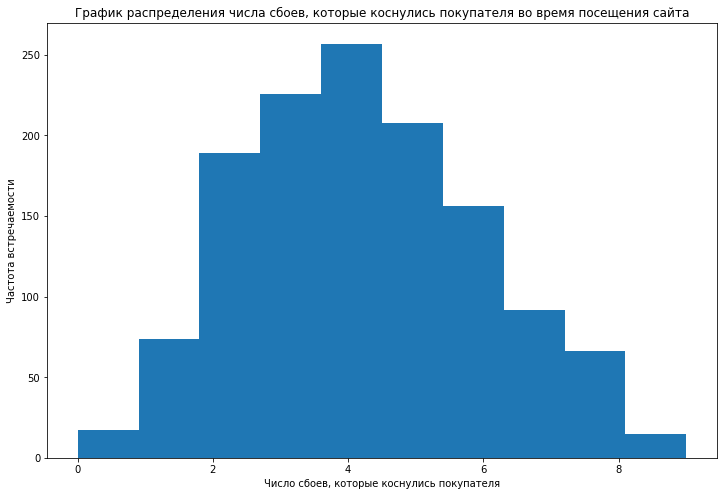

In [46]:
ax = market_file['ошибка_сервиса'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Число сбоев, которые коснулись покупателя');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения числа сбоев, которые коснулись покупателя во время посещения сайта");

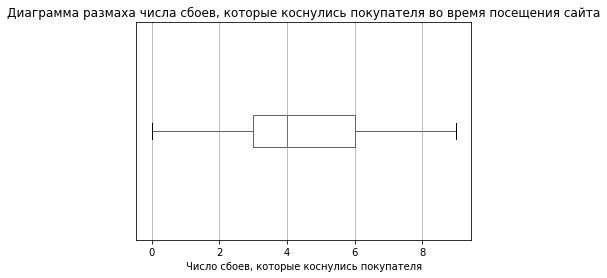

In [47]:
ax = market_file['ошибка_сервиса'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Число сбоев, которые коснулись покупателя")
ax.set_title("Диаграмма размаха числа сбоев, которые коснулись покупателя во время посещения сайта");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

Рассмотрим среднее и медианное значения числа сбоев:

In [48]:
print(f'Среднее значение числа сбоев, которые коснулись покупателя во время посещения сайта: \
{market_file["ошибка_сервиса"].mean():.2f}')
print(f'Медианное значение числа сбоев, которые коснулись покупателя во время посещения сайта: \
{market_file["ошибка_сервиса"].median():.2f}')

Среднее значение числа сбоев, которые коснулись покупателя во время посещения сайта: 4.19
Медианное значение числа сбоев, которые коснулись покупателя во время посещения сайта: 4.00


В среднем пользователи встречаются с 4 сбоями во время посещения сайта. Для большинства пользователей характерно значение от 3 до 6 за посещение.

Рассмотрим распределение среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца:

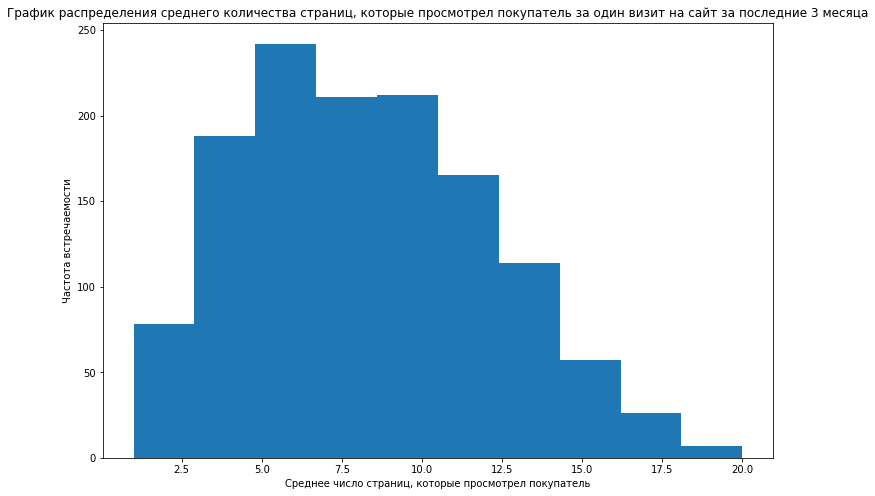

In [49]:
ax = market_file['страниц_за_визит'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Среднее число страниц, которые просмотрел покупатель');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднего количества страниц, \
которые просмотрел покупатель за один визит на сайт за последние 3 месяца");

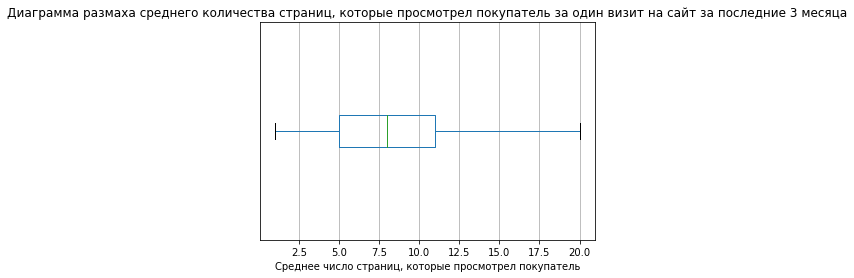

In [50]:
ax = market_file['страниц_за_визит'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Среднее число страниц, которые просмотрел покупатель")
ax.set_title("Диаграмма размаха среднего количества страниц, \
которые просмотрел покупатель за один визит на сайт за последние 3 месяца");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

Рассмотрим среднее и медианное значения числа просмотренных пользователем страниц:

In [51]:
print(f'Среднее значение числа страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца: \
{market_file["страниц_за_визит"].mean():.2f}')
print(f'Медианное значение числа страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца: \
{market_file["страниц_за_визит"].median():.2f}')

Среднее значение числа страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца: 8.18
Медианное значение числа страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца: 8.00


В среднем пользователи просматривают за один визит на сайт около 8 страниц. Для большинства пользователей характерно значение от 5 до 11 страниц.

#### Исследовательский анализ market_money

Рассмотрим распределение выручки, которую получил магазин от покупателя в течение определенного периода. Вспомним структуру данных:

In [52]:
display(market_money.head())
market_money['период'].value_counts()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: период, dtype: int64

В данных встречаются данные за текущий и предыдущие месяцы. Построим общий график распределения выручки, которую получил магазин от покупателя:

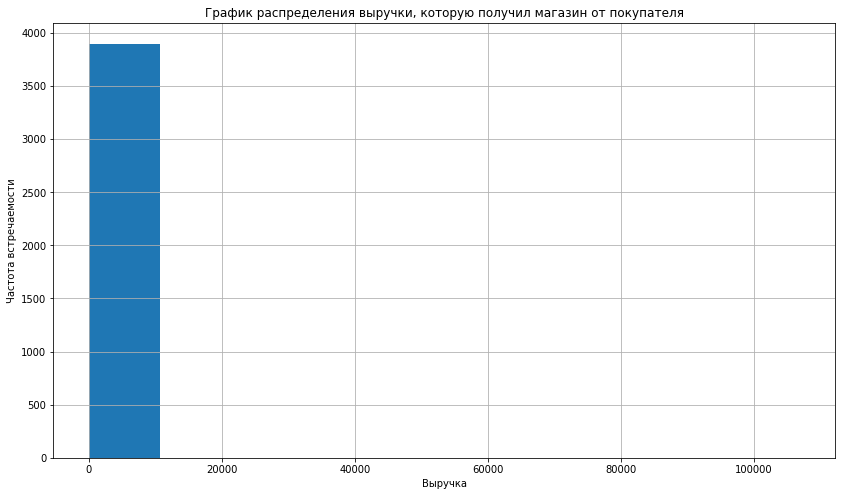

In [53]:
ax = market_money["выручка"].hist(figsize = (14, 8))
ax.set_xlabel("Выручка")
ax.set_ylabel("Частота встречаемости")
ax.set_title("График распределения выручки, которую получил магазин от покупателя");

Вероятно, в данных имются выбросы. Проверим записи:

In [54]:
market_money[market_money['выручка'] > 80000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Имеется одна запись с экстремально большим относительно других записей значением выручку. Это выброс, избавимся от него:

In [55]:
market_money = market_money.loc[market_money['выручка'] < 80000]

Снова построим интересующий график:

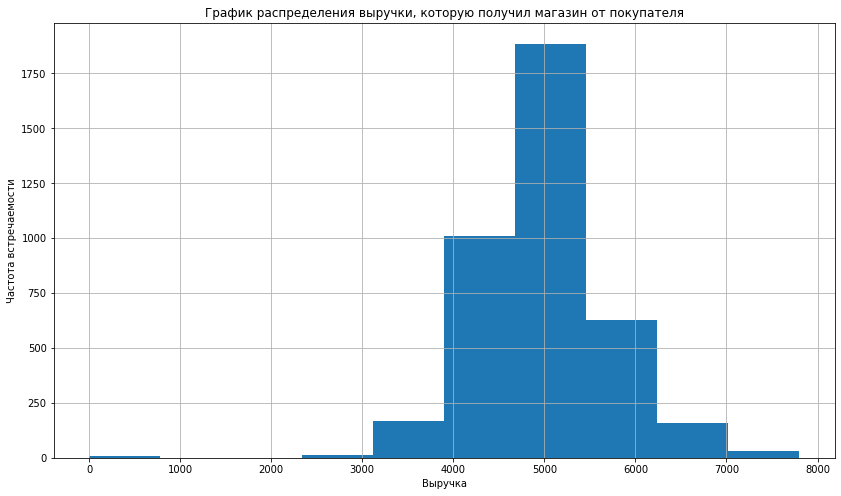

In [56]:
ax = market_money["выручка"].hist(bins = 10, figsize = (14, 8))
ax.set_xlabel("Выручка")
ax.set_ylabel("Частота встречаемости")
ax.set_title("График распределения выручки, которую получил магазин от покупателя");

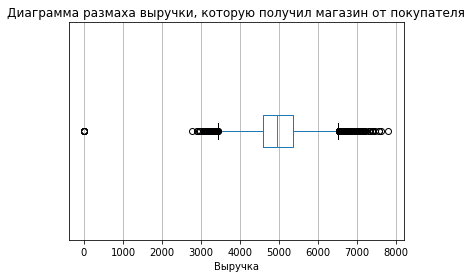

In [57]:
ax = market_money['выручка'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Выручка")
ax.set_title("Диаграмма размаха выручки, которую получил магазин от покупателя");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

Теперь построим график, на котором отдельно изображены данные за предыдущие и текущий месяцы:

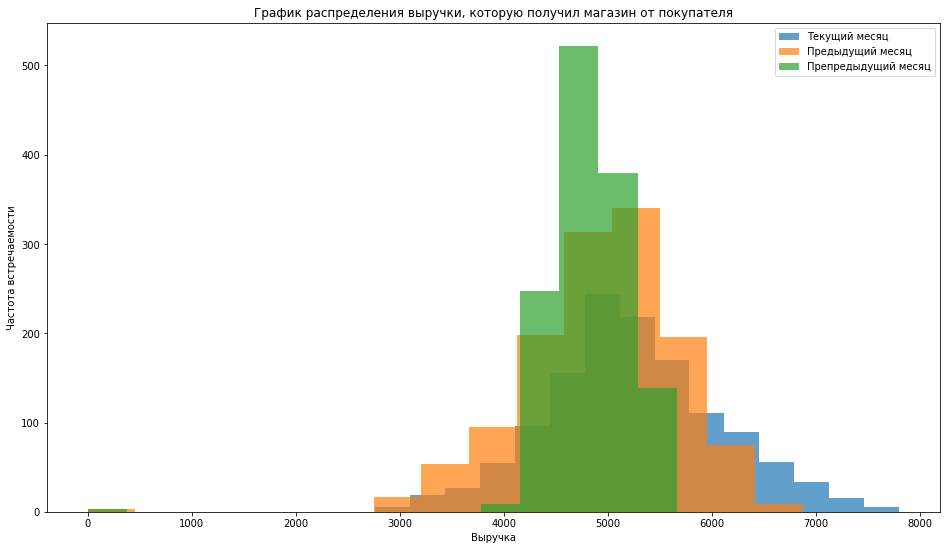

In [58]:
plt.figure()
ax = market_money.loc[market_money["период"] == "текущий_месяц"]['выручка'].plot(kind="hist", bins = 15, label = 'Текущий месяц', \
                                                                             alpha = 0.7, figsize = (16, 9));
market_money.loc[market_money["период"] == "предыдущий_месяц"]['выручка'].plot(kind="hist", bins = 15, label = 'Предыдущий месяц', \
                                                                            alpha = 0.7, ax = ax);
market_money.loc[market_money["период"] == "препредыдущий_месяц"]['выручка'].plot(kind="hist", bins = 15, label = 'Препредыдущий месяц', \
                                                                            alpha = 0.7, ax = ax);
plt.legend(loc='upper right')
ax.set_xlabel("Выручка");
ax.set_ylabel("Частота встречаемости");
ax.set_title("График распределения выручки, которую получил магазин от покупателя");

Выведем на экран средние и медианные значения выручки:

In [59]:
print(f'Среднее значение выручки, которую получил магазин от покупателя за два месяца: {market_money["выручка"].mean():.2f}')
print(f'Медианное значение выручки, которую получил магазин от покупателя за два месяца: {market_money["выручка"].median():.2f}\n')

print(f'Среднее значение выручки, которую получил магазин от покупателя за препредыдущий месяц: \
{market_money.loc[market_money["период"] == "препредыдущий_месяц"]["выручка"].mean():.2f}')
print(f'Медианное значение выручки, которую получил магазин от покупателя за препредыдущий месяц: \
{market_money.loc[market_money["период"] == "препредыдущий_месяц"]["выручка"].median():.2f}\n')

print(f'Среднее значение выручки, которую получил магазин от покупателя за предыдущий месяц: \
{market_money.loc[market_money["период"] == "предыдущий_месяц"]["выручка"].mean():.2f}')
print(f'Медианное значение выручки, которую получил магазин от покупателя за предыдущий месяц: \
{market_money.loc[market_money["период"] == "предыдущий_месяц"]["выручка"].median():.2f}\n')

print(f'Среднее значение выручки, которую получил магазин от покупателя за текущий месяц: \
{market_money.loc[market_money["период"] == "текущий_месяц"]["выручка"].mean():.2f}')
print(f'Медианное значение выручки, которую получил магазин от покупателя за текущий месяц: \
{market_money.loc[market_money["период"] == "текущий_месяц"]["выручка"].median():.2f}\n')

Среднее значение выручки, которую получил магазин от покупателя за два месяца: 4999.58
Медианное значение выручки, которую получил магазин от покупателя за два месяца: 4957.00

Среднее значение выручки, которую получил магазин от покупателя за препредыдущий месяц: 4825.21
Медианное значение выручки, которую получил магазин от покупателя за препредыдущий месяц: 4809.00

Среднее значение выручки, которую получил магазин от покупателя за предыдущий месяц: 4936.92
Медианное значение выручки, которую получил магазин от покупателя за предыдущий месяц: 5005.00

Среднее значение выручки, которую получил магазин от покупателя за текущий месяц: 5236.79
Медианное значение выручки, которую получил магазин от покупателя за текущий месяц: 5179.60



А также построим соответствующий график:

In [60]:
period_list = ['Препредыдущий месяц', 'Предыдущий месяц', 'Текущий месяц']
mean_list = [market_money.loc[market_money["период"] == "препредыдущий_месяц"]["выручка"].mean(), \
             market_money.loc[market_money["период"] == "предыдущий_месяц"]["выручка"].mean(), \
             market_money.loc[market_money["период"] == "текущий_месяц"]["выручка"].mean()]
median_list = [market_money.loc[market_money["период"] == "препредыдущий_месяц"]["выручка"].median(), \
               market_money.loc[market_money["период"] == "предыдущий_месяц"]["выручка"].median(), \
               market_money.loc[market_money["период"] == "текущий_месяц"]["выручка"].median()]

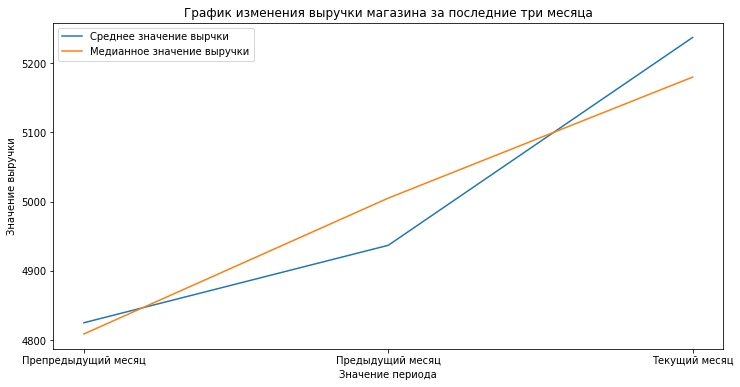

In [61]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(period_list, mean_list, label = 'Среднее значение вырчки')
ax.plot(period_list, median_list, label = 'Медианное значение выручки')
ax.legend(loc='upper left')
ax.set_xlabel("Значение периода")
ax.set_ylabel("Значение выручки")
ax.set_title("График изменения выручки магазина за последние три месяца");

В среднем значение выручки от покупателя растет с каждым месяцем. Однако по графику распределения видно, что с каждым новым месяцем гистограмма как бы расплывается. Это указывает на то, что становится больше покупателей, которые предоставляют выручку как выше, так и ниже среднего значения.

#### Исследовательский анализ market_time

Рассмотрим распределение времени, которое покупатель провёл на сайте в течение определенного периода. Вспомним структуру данных и проверим распределение данных по периодам:

In [62]:
display(market_time.head())
market_time["период"].value_counts()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


текущий_месяц       1300
предыдущий_месяц    1300
Name: период, dtype: int64

В данных встречаются данные за текущий и предыдущий месяцы. Построим общий график распределения времени, которое пользователи проводили на сайте:

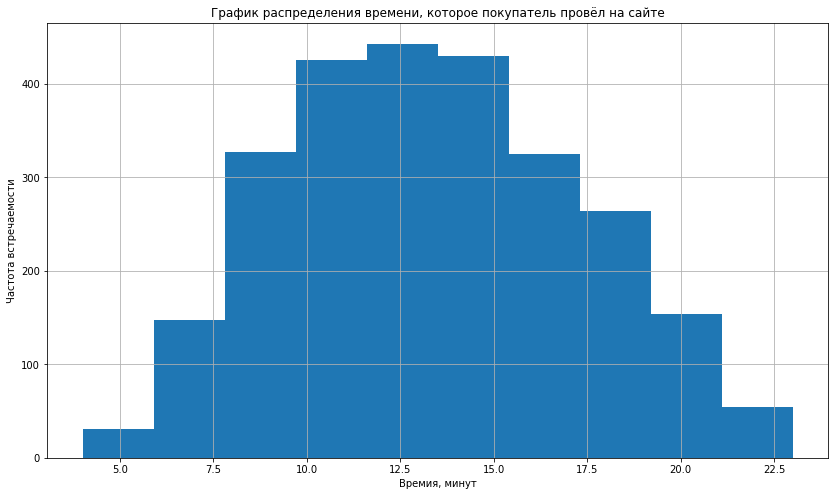

In [63]:
ax = market_time["минут"].hist(figsize = (14, 8))
ax.set_xlabel("Времия, минут")
ax.set_ylabel("Частота встречаемости")
ax.set_title("График распределения времени, которое покупатель провёл на сайте");

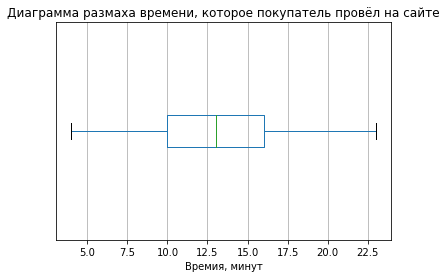

In [64]:
ax = market_time['минут'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Времия, минут")
ax.set_title("Диаграмма размаха времени, которое покупатель провёл на сайте");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

Теперь построим график, на котором отдельно изображены данные за предыдущий и текущий месяца:

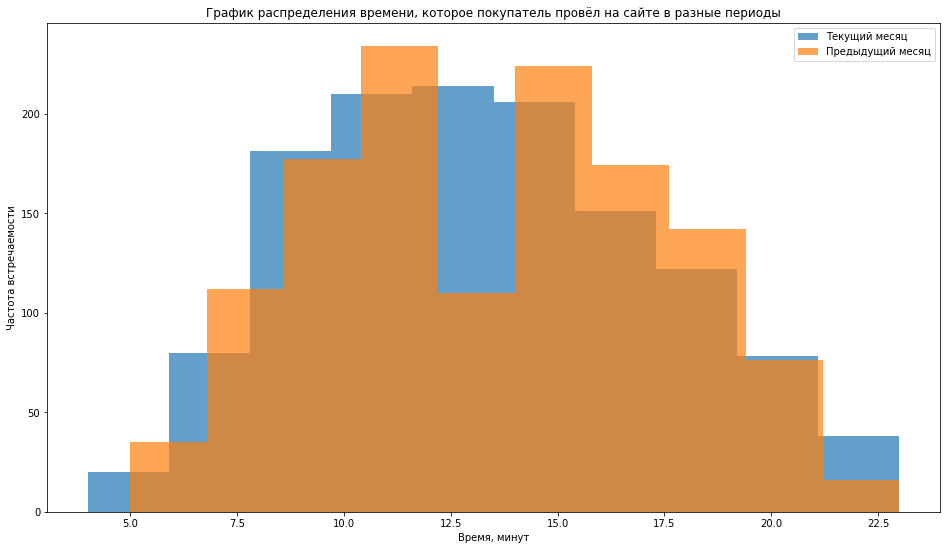

In [65]:
plt.figure()
ax = market_time.loc[market_time["период"] == "текущий_месяц"]['минут'].plot(kind="hist", bins = 10, label = 'Текущий месяц', \
                                                                             alpha = 0.7, figsize = (16, 9));
market_time.loc[market_time["период"] == "предыдущий_месяц"]['минут'].plot(kind="hist", bins = 10, label = 'Предыдущий месяц', \
                                                                            alpha = 0.7, ax = ax);
plt.legend(loc='upper right')
ax.set_xlabel("Время, минут")
ax.set_ylabel("Частота встречаемости")
ax.set_title("График распределения времени, которое покупатель провёл на сайте в разные периоды");

Выведем на экран средние и медианные значения времени:

In [66]:
print(f'Среднее значение времени, проведенного на сайте пользователями за два месяца: {market_time["минут"].mean():.2f}')
print(f'Медианное значение времени, проведенного на сайте пользователями за два месяца: {market_time["минут"].median():.2f}\n')

print(f'Среднее значение времени, проведенного на сайте пользователями за предыдущий месяц: \
{market_time.loc[market_time["период"] == "предыдущий_месяц"]["минут"].mean():.2f}')
print(f'Медианное значение времени, проведенного на сайте пользователями за предыдущий месяц: \
{market_time.loc[market_time["период"] == "предыдущий_месяц"]["минут"].median():.2f}\n')

print(f'Среднее значение времени, проведенного на сайте пользователями за текущий месяц: \
{market_time.loc[market_time["период"] == "текущий_месяц"]["минут"].mean():.2f}')
print(f'Медианное значение времени, проведенного на сайте пользователями за текущий месяц: \
{market_time.loc[market_time["период"] == "текущий_месяц"]["минут"].median():.2f}\n')

Среднее значение времени, проведенного на сайте пользователями за два месяца: 13.34
Медианное значение времени, проведенного на сайте пользователями за два месяца: 13.00

Среднее значение времени, проведенного на сайте пользователями за предыдущий месяц: 13.47
Медианное значение времени, проведенного на сайте пользователями за предыдущий месяц: 13.00

Среднее значение времени, проведенного на сайте пользователями за текущий месяц: 13.20
Медианное значение времени, проведенного на сайте пользователями за текущий месяц: 13.00



Среднее время, проведенное пользователями на сайте в предыдущем месяце, чуть больше, чем в текущем. В обоих случаях оно примерно равно 13 минутам за визит. Большинство пользователей проводит на сайте от 10 до 16 минут.

#### Исследовательский анализ money

Рассмотрим распределение среднемесячной прибыли от покупателя за последние 3 месяца. Вспомним структуру данных:

In [67]:
money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Построим график распределения средней прибыли от покупателей за последние три месяца:

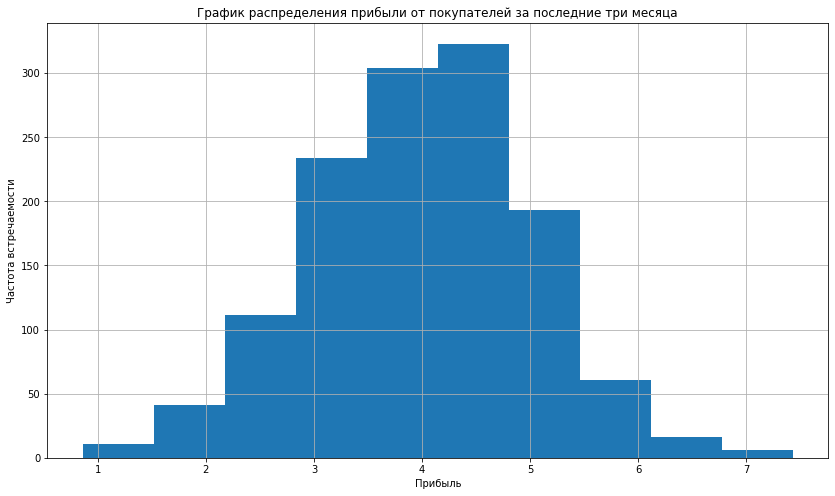

In [68]:
ax = money["прибыль"].hist(figsize = (14, 8))
ax.set_xlabel("Прибыль")
ax.set_ylabel("Частота встречаемости")
ax.set_title("График распределения прибыли от покупателей за последние три месяца");

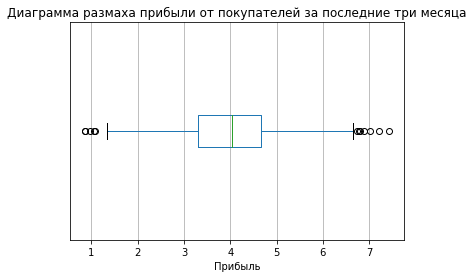

In [69]:
ax = money['прибыль'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Прибыль")
ax.set_title("Диаграмма размаха прибыли от покупателей за последние три месяца");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

Выведем на экран среднее и медианное значения прибыли:

In [70]:
print(f'Среднее значение среднемесячной прибыли от покупаталей за последние три месяца: {money["прибыль"].mean():.2f}')
print(f'Медианное значение среднемесячной прибыли от покупаталей за последние три месяца: {money["прибыль"].median():.2f}')

Среднее значение среднемесячной прибыли от покупаталей за последние три месяца: 4.00
Медианное значение среднемесячной прибыли от покупаталей за последние три месяца: 4.04


Среднее значение прибыли равно 4. Для большинтсва клиентов характерно значение от 3.2 до 4.6.

#### Отбор клиентов

 Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Реализуем это с помощью датафрейма market_money:

In [71]:
print(market_money.head())
print(market_money['период'].value_counts())

       id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1299
Name: период, dtype: int64


In [72]:
#список, в который будем добавлять ID нужных клиентов
active_customer_id = []
for customer_id in list(market_money['id']):
    #выделяем из market_money данные одного клиента
    customer_df = market_money.loc[market_money['id'] == customer_id]
    #проверяем, что клиент делал покупки за последние три месяца
    if customer_df.shape[0] == 3:
        gain_flag = True
        for gain in customer_df['выручка']:
            if int(gain) == 0:
                gain_flag = False
        #добавляем ID клиента в список, если там его еще нет
        if gain_flag:
            active_customer_id.append(customer_id) if customer_id not in active_customer_id else active_customer_id

In [73]:
print(f'Клиентов с покупательской активностью не менее трех месяцев: {len(active_customer_id)}')

Клиентов с покупательской активностью не менее трех месяцев: 1296


Создадим новые датафреймы с учетом покупательской активности клиентов:

In [74]:
market_money_active = market_money.loc[market_money['id'].isin(active_customer_id)]
market_time_active = market_time.loc[market_time['id'].isin(active_customer_id)]
market_file_active = market_file.loc[market_file['id'].isin(active_customer_id)]

#### Выводы по третьему этапу
- проведен исследовательский анализ исходных данных;
- выявлены самая популярная и не популярная категории товаров для пользователей - это "Товары для детей" и "Кухонная посуда" соответственно;
- для количественных признаков построены графики распределения, диаграммы рассеяния и рассчитаны средние и медианные значения;
- установлено, что в среднем за последние три месяца выручка магазина от покупателя растет; 
- в таблицу market_file на основе количественного признака акционные_покупки добавлен новый категорильный признак акционные_покупки_категориальный;
- выполнен отбор клиентов с покупательской активностью не менее трёх месяцев. С учетом этого созданы новые датафреймы market_money_active, market_time_active, market_file_active.

## Объединение таблиц

#### Объединение датафреймов

Объединим данные из market_file, market_money, market_time с учетом покупательской активности. Для этого воспользуемся созданными датафреймами market_money_active, market_time_active и market_file_active. В исходных таблицах данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода. Вспомним, как выглядят данные:

In [75]:
market_file_active.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,акционные_покупки_категориальный
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,высокая
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,низкая
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,высокая
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,высокая
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,средняя


In [76]:
market_money_active.head()

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


In [77]:
market_time_active.head()

,id,период,минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13


Создадим вспомогательные датафреймы для дальнейшего объединения:

In [78]:
#создадим вспомогательные датафреймы из таблицы market_time_active
market_time_active_pred = market_time_active.loc[market_time_active['период'] == 'предыдущий_месяц']
market_time_active_pred = market_time_active_pred.rename(columns = {'минут': 'минут_за_предыдущий_месяц'})

market_time_active_current = market_time_active.loc[market_time_active['период'] == 'текущий_месяц']
market_time_active_current = market_time_active_current.rename(columns = {'минут': 'минут_за_текущий_месяц'})



#создадим вспомогательные датафреймы из таблицы market_money_active
market_money_active_pred = market_money_active.loc[market_money_active['период'] == 'предыдущий_месяц']
market_money_active_pred = market_money_active_pred.rename(columns = {'выручка': 'выручка_за_предыдущий_месяц'})

market_money_active_current = market_money_active.loc[market_money_active['период'] == 'текущий_месяц']
market_money_active_current = market_money_active_current.rename(columns = {'выручка': 'выручка_за_текущий_месяц'})

market_money_active_pred_pred = market_money_active.loc[market_money_active['период'] == 'препредыдущий_месяц']
market_money_active_pred_pred = market_money_active_pred_pred.rename(columns = {'выручка': 'выручка_за_препредыдущий_месяц'})

Объединим данные в датафрейм customer_info:

In [79]:
#Объединение market_file_active c ифнормацией из market_time_active
customer_info = pd.merge(market_file_active, market_time_active_pred[['id', 'минут_за_предыдущий_месяц']], \
                   left_on = 'id', right_on = 'id')
customer_info = pd.merge(customer_info, market_time_active_current[['id', 'минут_за_текущий_месяц']], \
                   left_on = 'id', right_on = 'id')

#Объединение market_file_active c ифнормацией из market_money_active
customer_info = pd.merge(customer_info, market_money_active_pred_pred[['id', 'выручка_за_препредыдущий_месяц']], \
                   left_on = 'id', right_on = 'id')
customer_info = pd.merge(customer_info, market_money_active_current[['id', 'выручка_за_текущий_месяц']], \
                   left_on = 'id', right_on = 'id')
customer_info = pd.merge(customer_info, market_money_active_pred[['id', 'выручка_за_предыдущий_месяц']], \
                   left_on = 'id', right_on = 'id')

Выведем на экран первые строки итогового датафрейма:

In [80]:
customer_info.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,акционные_покупки_категориальный,минут_за_предыдущий_месяц,минут_за_текущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,выручка_за_предыдущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,высокая,12,10,4472.0,4971.6,5216.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,низкая,8,13,4826.0,5058.4,5457.5
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,высокая,11,13,4793.0,6610.4,6158.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,высокая,8,11,4594.0,5872.5,5807.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,средняя,10,10,5124.0,5388.5,4738.5


#### Выводы по четвертому этапу
- произведено объединение таблиц market_file, market_money, market_time в один датафрейм customer_info с учетом покупательской активности пользователей.

## Корреляционный анализ

#### Матрица корреляции

Проведем корреляционный анализ признаков в итоговой таблице customer_info. Для этого построим матрицу корреляции:

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минут_за_предыдущий_месяц', 'минут_за_текущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц', 'выручка_за_предыдущий_месяц']


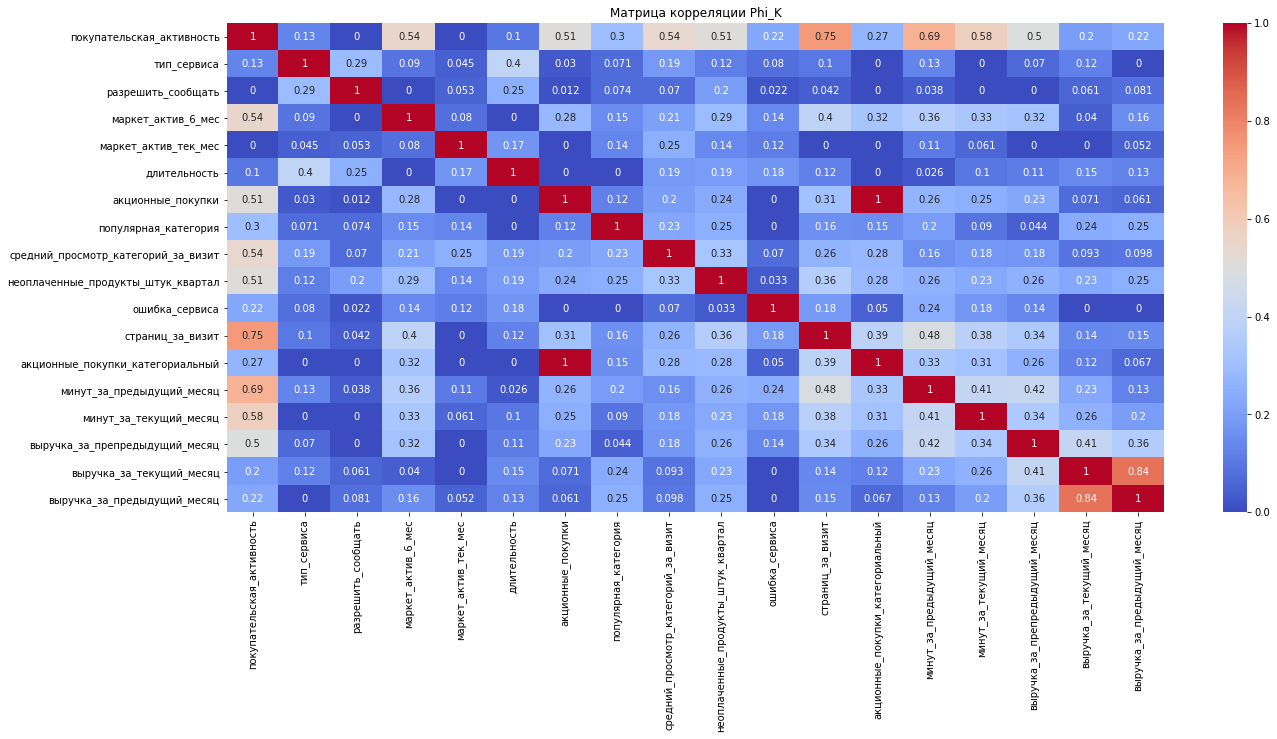

In [82]:
corr_matrix = customer_info.drop('id', axis = 1).phik_matrix();
plt.figure(figsize=(21, 9));
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');
plt.title('Матрица корреляции Phi_K');
plt.show();

Обнаружена высокая корреляция между признакими акционные_покупки и акционные_покупки_категориальный, что логично, ведь второй был создан искуственно на основе первого. Чтобы исключить мультиколлинеарности в данном случае, признак акционные_покупки использовать при обучении не будем.  
В остальных случаях высоких коэффициентов корреляции (0.9+) не видно, следовательно, мультиколлинеарности в данных нет. Выделим признаки, которые имеют наиболее выраженную связь с целевым (покупаьельская активность) - это среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца и временя проведённое на сайте за предыдущий месяц.

#### Выводы по пятому этапу
- проведен корреляционный анализ данных для моделирования;
- выявлены признаки, имеющие наибольшее выраженную связь с целевым: количество просмотренных на сайте страниц и время, проведенное на сайте в предыдущем месяце;
- мультиколлинеарности не обнаружено.

## Использование пайплайнов

Построим пайплайн для обучения моделей

#### Подготовка данных

Вспомним, как выглядят данные:

In [83]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

Зададим константы для фиксации начального состояния моделей и доли тестовой выборки:

In [84]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Разобьем данные на тренировочную и тестовыую выборки с учетом стратификации:

In [85]:
X_train, X_test, example_train, example_test = train_test_split(
    customer_info.drop(['покупательская_активность', 'id'], axis=1),
    customer_info['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = customer_info['покупательская_активность'])

Подготовим данные: приведем целевой признак к бинарному виду. Факт снижения покупательская активности закодируем как 1, а отсутствие ее изменения - 0. Используем для этого LabelEncoder:

In [86]:
label_encoder = LabelEncoder()
label_encoder.fit(example_train);
y_train = label_encoder.transform(example_train)
y_test = label_encoder.transform(example_test) 
pd.DataFrame(y_train, example_train, columns=['LabelEncoder'])

,LabelEncoder
покупательская_активность,
Прежний уровень,0
Снизилась,1
Прежний уровень,0
Прежний уровень,0
Снизилась,1
...,...
Прежний уровень,0
Прежний уровень,0
Снизилась,1


Теперь определимся с метрикой. Критичной в данном случае является ошибка False Negative. Она заключается в том, что модель предскажет неизменность покупательской активности, когда на самом деле активность снизится. Тогда получится, что магазин не предпримет попыток удерживать активность постоянных клиентов и понесет убытки. В данном случае необходимо увеличивать метрику Recall.

Теперь целевой признак представлен в бинарном виде.

#### Создание пайплайнов

Выделим качественные и количественные признаки:

In [87]:
ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['акционные_покупки_категориальный']
num_columns = customer_info.drop(['id', 'акционные_покупки'], axis = 1).select_dtypes(include = 'number').columns

Создадим пайплайн для OHE-кодирования:

In [88]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

Создаем пайплайн для ORD-кодирования:

In [89]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['низкая', 'средняя', 'высокая']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создадим общий пайплайн для подготовки данных:

In [90]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создадим итоговый пайплайн, в котором будет подготовка данных и модель:

In [91]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Определим параметры для перебора в RandomizedSearchCV:

In [92]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    #словарь для модели SVC
    {
        'models': [SVC(
            kernel = 'linear', probability=True,
        )],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

Зададим условия для поиска гиперпараметров с помощью RandomizedSearchCV:

In [93]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='recall',
    random_state = RANDOM_STATE,
    n_jobs=-1
)

#### Поиск оптимальных параметров

Выполним поиск оптимальных параметров:

In [94]:
randomized_search.fit(X_train, y_train);

Выведем на экран лучшую модель:

In [95]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                        

In [96]:
print (f'Метрика лучшей модели на тренировочной выборке: {randomized_search.best_score_:.5f}')

Метрика лучшей модели на тренировочной выборке: 0.74930


Рассмотрим метрику модели на тестовой выборке:

In [97]:
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика Recall на тестовой выборке: {recall_score(y_test, y_test_pred)}')

Метрика Recall на тестовой выборке: 0.8130081300813008


В данном случае лучшей оказалась модель на основе метода опорных векторов с линейным ядром и параметром регуляризации С равным 5. Ее метрика Recall составляет 75% на тренировочной выборке и 80% на тестовой.

#### Выводу по шестому этапу
- выполнена подготовка данных для обучения моделей;
- созданы пайплайны для обучения моделей;
- выполнен поиск оптимальных параметров. Лучшая модель - на основе метода опорных векторов с полиномаильным ядром;
- метрика модели составлятет 75% на тренировочной выборке и 79% на тестовой.

## Анализ важности признаков

#### Оценка важность признаков

С помощью библиотеки shap построим график, отражающий важность признаков в лучшей модели:

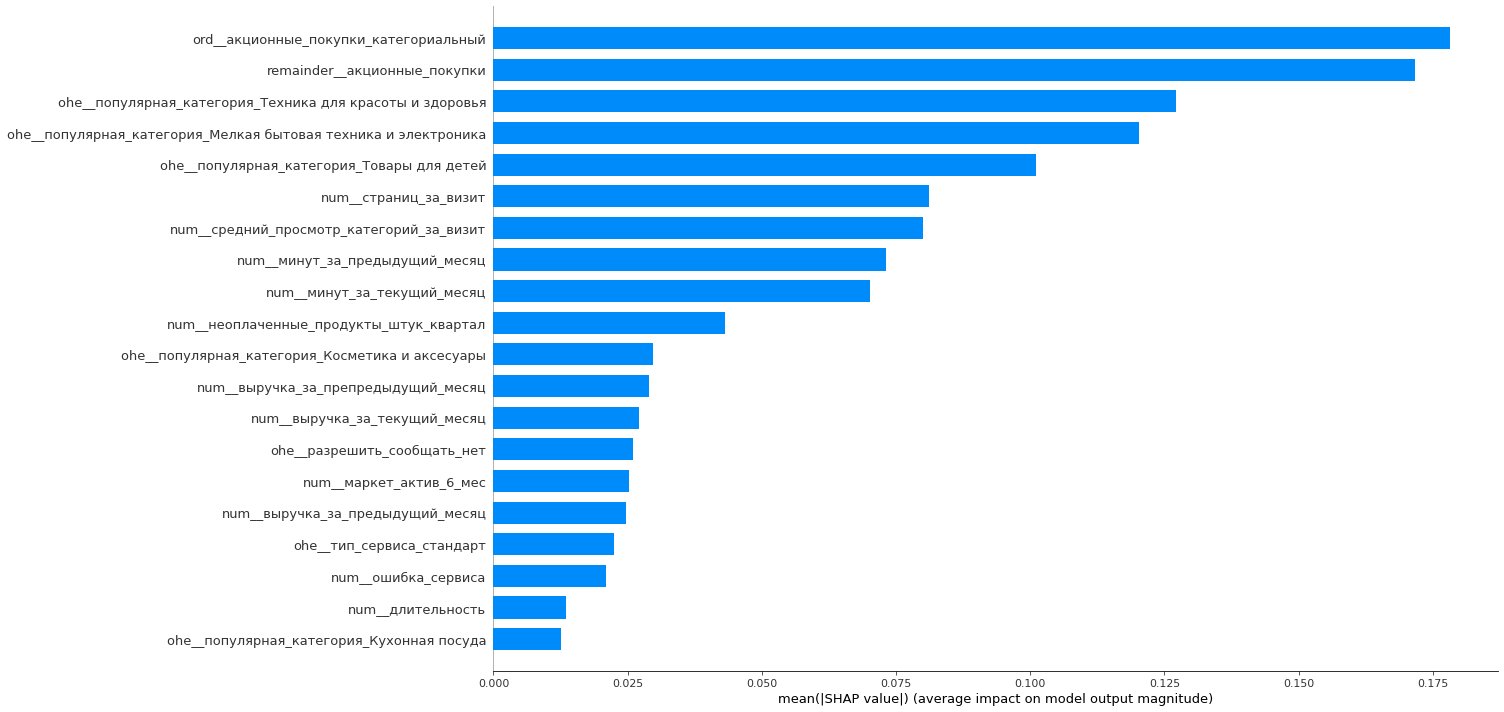

In [98]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
shap_values = explainer(X_test_2) 
shap.summary_plot(shap_values, plot_type = 'bar', plot_size = (21, 10))

Наибольшее влияние на целевой оказывют такие признаки, как количество просмотренных страниц сайта за визит, время, проведенное на сайте в предыдущем месяце, количество просмотренных категорий товаров на сайте за один визит и время, проведенное на сайте в текущем месяце.  
Наименьшее влияние оказывают следующие признаки: отсутствие согласия на рассылку о товарах, количество сбоев на сайте, выручка за предыдущий месяц, длительность регистрации пользователя, тип сервиса, а также факт увлеченностью такими категориями товаров как "Кухонная посуда" и "Косметика и аксессуары".

#### Рекомендации 

Так как самыми значимыми оказались признаки, описывающие поведение пользователей на сайте, следует расширить перечень собираемой  в этой области информации. Например, добавить такие признаки, как факт перехода по ссылкам на похожие товары или товары, часто покупаемые с искомым.

#### Выводы по седьмому этапу
- произведена оценка важности признаков;
- выделены признаки, имеющие наибольшее влияние на целевой. Это время, проведенное на сайте, количетво просмотренных товаров и страниц;
- выделены признаки, имеющие наименьшее влияние на целевой. Это длительность регистрации, тип сервиса, количество сбоев на сайте и увлечение непопулярными категориями;
- даны рекомендации по сбору дополнительной информации о поведении пользователей на сайте для более точного моделирования бизнес-процессов и принятия решений.

## Сегментация покупателей

#### Подготовка данных

Выберем группу покупателей, проанализируем ее и дадим предложения по увеличению ее покупательской активности. Выделим следующий сегмент: клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом. Воспользуемся данными, полученными в результате моделирования:

In [99]:
X_test['покупательская_активность_предсказанный'] = y_test_pred

In [100]:
customers_tech = X_test.loc[(X_test['популярная_категория'].isin(['Мелкая бытовая техника и электроника',\
                                                'Техника для красоты и здоровья'])) & \
                  (X_test['покупательская_активность_предсказанный'] == 1)]

Из общего датасета уберем записи, попавшие в выбранный сегмент:

In [101]:
X_test = X_test.drop(customers_tech.index)

Также рассмотрим данными о среднемесячной прибыли выбранных клиентов за последние 3 месяца:

In [102]:
money_tech = money.loc[customers_tech.index]
money = money.loc[X_test.index]

#### Анализ money

Построим график распределения средней прибыли от выбранных клиентов и остальных покупателей за последние три месяца:

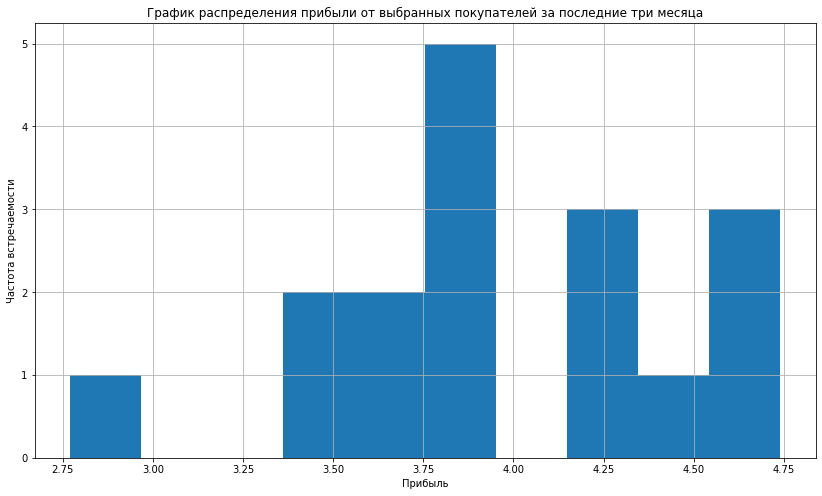

In [103]:
ax = money_tech["прибыль"].hist(figsize = (14, 8))
ax.set_xlabel("Прибыль")
ax.set_ylabel("Частота встречаемости")
ax.set_title("График распределения прибыли от выбранных покупателей за последние три месяца");

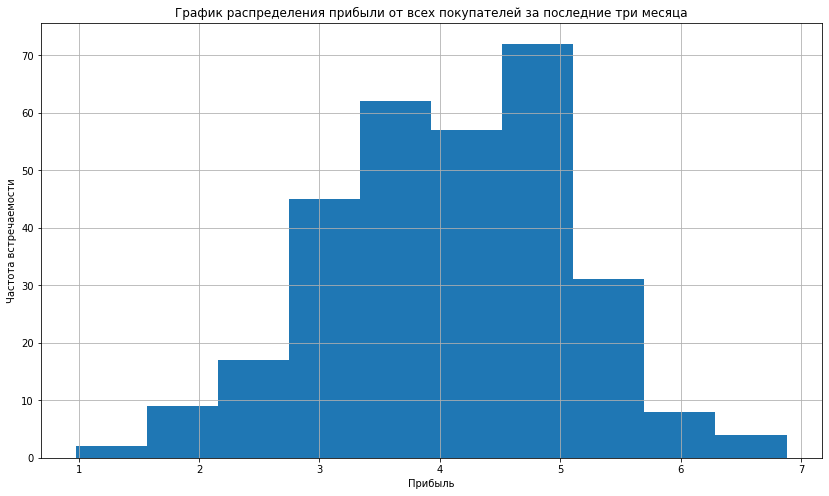

In [104]:
ax = money["прибыль"].hist(figsize = (14, 8))
ax.set_xlabel("Прибыль")
ax.set_ylabel("Частота встречаемости")
ax.set_title("График распределения прибыли от всех покупателей за последние три месяца");

А также диаграммы размаха:

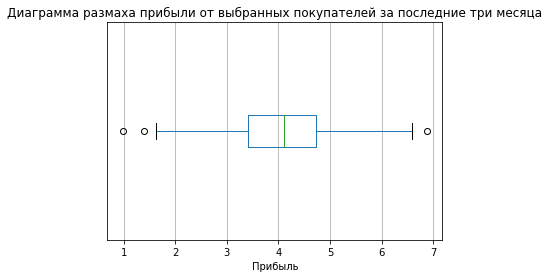

In [105]:
ax = money['прибыль'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Прибыль")
ax.set_title("Диаграмма размаха прибыли от выбранных покупателей за последние три месяца");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

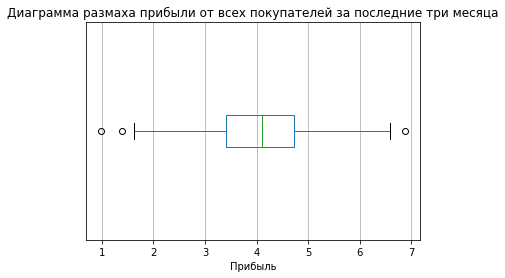

In [106]:
ax = money['прибыль'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Прибыль")
ax.set_title("Диаграмма размаха прибыли от всех покупателей за последние три месяца");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

In [107]:
print(f'Среднее значение прибыли от выбранных покупателей за последние три месяца: {money_tech["прибыль"].mean():.2f}')
print(f'Среднее значение прибыли от всех покупателей за последние три месяца: {money["прибыль"].mean():.2f}')
print()
print(f'Медианное значение прибыли от выбранных покупателей за последние три месяца: {money_tech["прибыль"].median():.2f}')
print(f'Медианное значение прибыли от всех покупателей за последние три месяца: {money["прибыль"].median():.2f}')

Среднее значение прибыли от выбранных покупателей за последние три месяца: 3.97
Среднее значение прибыли от всех покупателей за последние три месяца: 4.07

Медианное значение прибыли от выбранных покупателей за последние три месяца: 3.89
Медианное значение прибыли от всех покупателей за последние три месяца: 4.10


В среднем клиенты выбранной категории приносят приносят почти на 10% меньше прибыли, чем остальные клиенты. Если для большинства покупателей из общей массы клиентов характерно значение прибыли в диапазоне 3.2 - 4.8, то для большинства покупателей из выбранного сегмента этот диапазон составляет 3.2 - 4.2. Следовательно, прибыль от данного сегмента хотелось бы улучшить.

<div class="alert alert-info"> <b>Работу с результатами моделирования добавил.</b> </div>

#### Анализ признаков

Проанализируем признаки, влияние которых носит сильнейший характер на покупательскую способность согласно пункту 7:

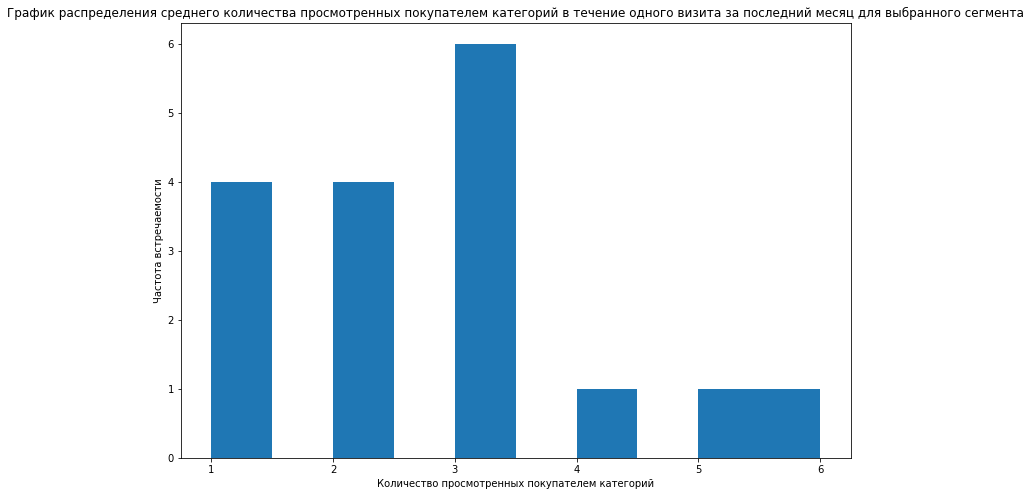

In [108]:
ax = customers_tech['средний_просмотр_категорий_за_визит'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Количество просмотренных покупателем категорий');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднего количества просмотренных покупателем категорий \
в течение одного визита за последний месяц для выбранного сегмента");

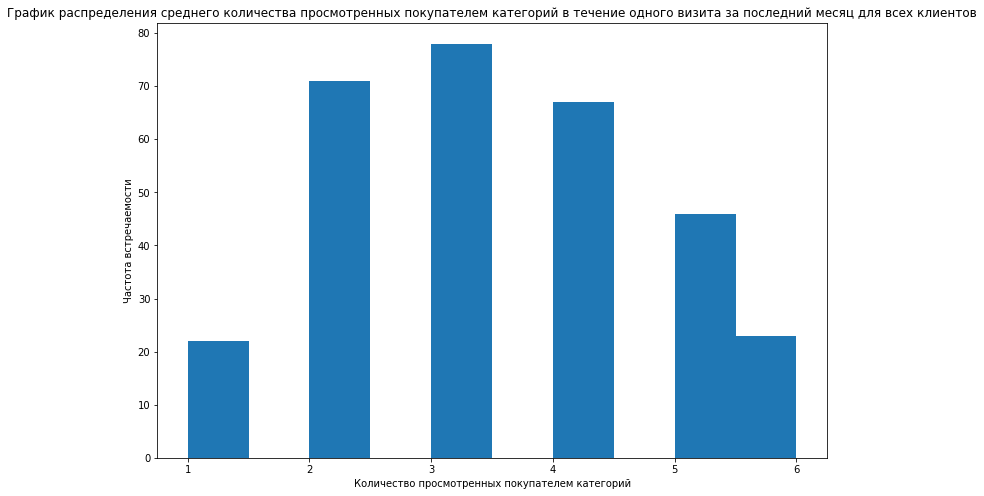

In [109]:
ax = X_test['средний_просмотр_категорий_за_визит'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Количество просмотренных покупателем категорий');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднего количества просмотренных покупателем категорий \
в течение одного визита за последний месяц для всех клиентов");

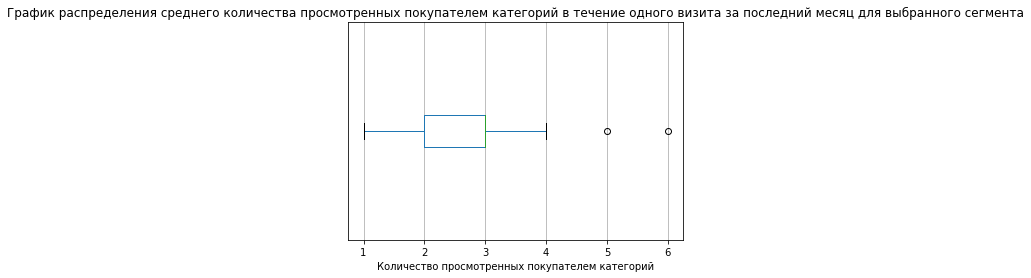

In [110]:
ax = customers_tech['средний_просмотр_категорий_за_визит'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Количество просмотренных покупателем категорий")
ax.set_title("График распределения среднего количества просмотренных покупателем категорий \
в течение одного визита за последний месяц для выбранного сегмента");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

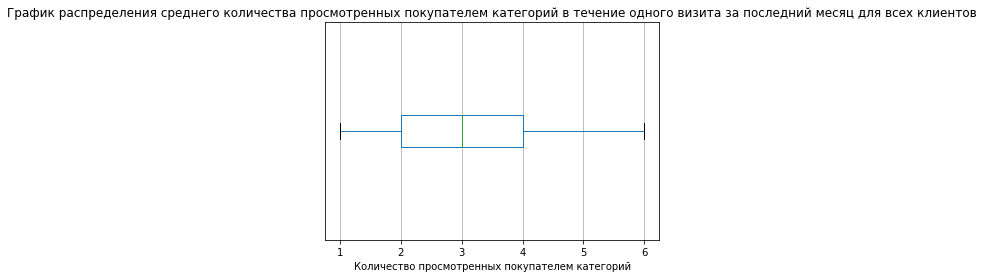

In [111]:
ax = X_test['средний_просмотр_категорий_за_визит'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Количество просмотренных покупателем категорий")
ax.set_title("График распределения среднего количества просмотренных покупателем категорий \
в течение одного визита за последний месяц для всех клиентов");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

In [112]:
print(f'Среднее значение количества просмотренных покупателем категорий \
в течение одного визита для выбранного сегмента: \
{customers_tech["средний_просмотр_категорий_за_визит"].mean():.2f}')
print(f'Медианное значение количества просмотренных покупателем категорий \
в течение одного визита для выбранного сегмента: \
{customers_tech["средний_просмотр_категорий_за_визит"].median():.2f}')
print()
print(f'Среднее значение количества просмотренных покупателем категорий \
в течение одного визита для всех клиентов: \
{X_test["средний_просмотр_категорий_за_визит"].mean():.2f}')
print(f'Медианное значение количества просмотренных покупателем категорий \
в течение одного визита для всех клиентов: \
{X_test["средний_просмотр_категорий_за_визит"].median():.2f}')

Среднее значение количества просмотренных покупателем категорий в течение одного визита для выбранного сегмента: 2.65
Медианное значение количества просмотренных покупателем категорий в течение одного визита для выбранного сегмента: 3.00

Среднее значение количества просмотренных покупателем категорий в течение одного визита для всех клиентов: 3.37
Медианное значение количества просмотренных покупателем категорий в течение одного визита для всех клиентов: 3.00


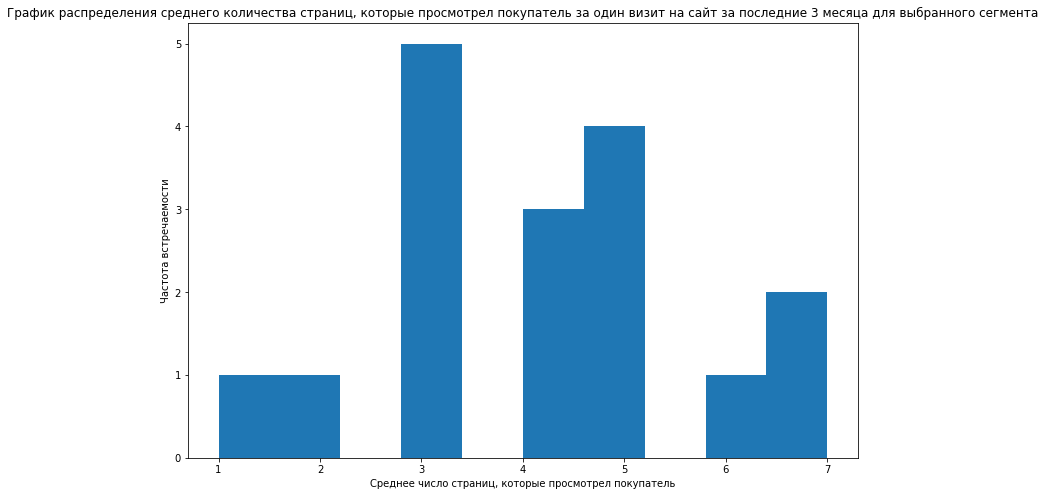

In [113]:
ax = customers_tech['страниц_за_визит'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Среднее число страниц, которые просмотрел покупатель');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднего количества страниц, \
которые просмотрел покупатель за один визит на сайт за последние 3 месяца для выбранного сегмента");

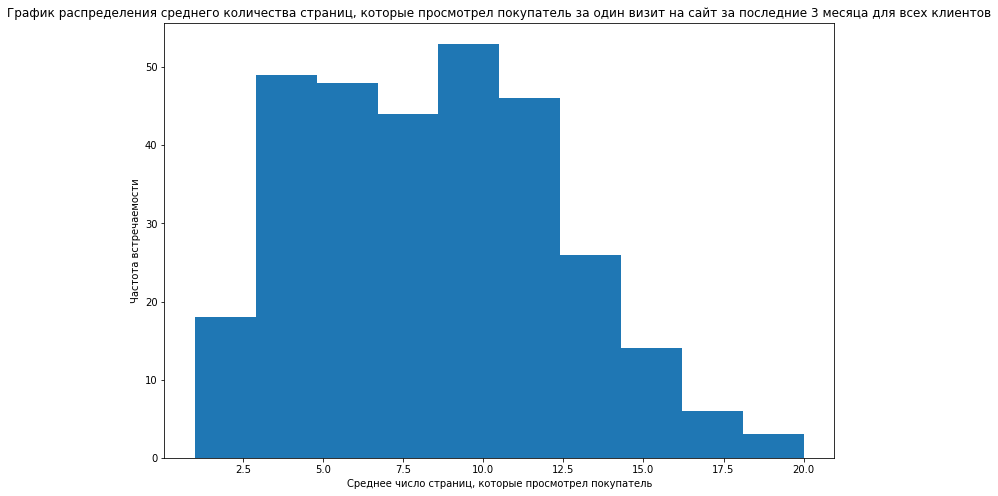

In [114]:
ax = X_test['страниц_за_визит'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Среднее число страниц, которые просмотрел покупатель');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднего количества страниц, \
которые просмотрел покупатель за один визит на сайт за последние 3 месяца для всех клиентов");

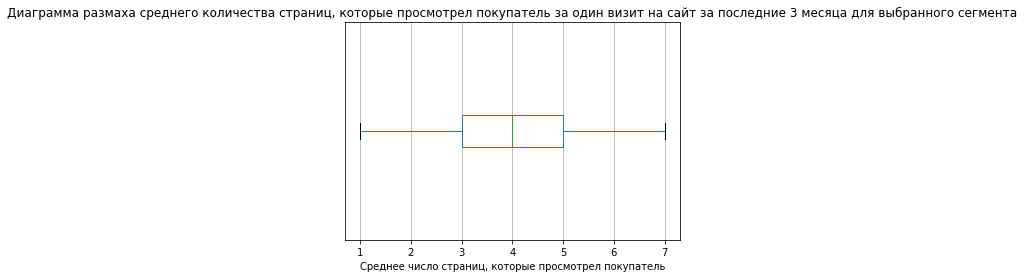

In [115]:
ax = customers_tech['страниц_за_визит'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Среднее число страниц, которые просмотрел покупатель")
ax.set_title("Диаграмма размаха среднего количества страниц, \
которые просмотрел покупатель за один визит на сайт за последние 3 месяца для выбранного сегмента");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

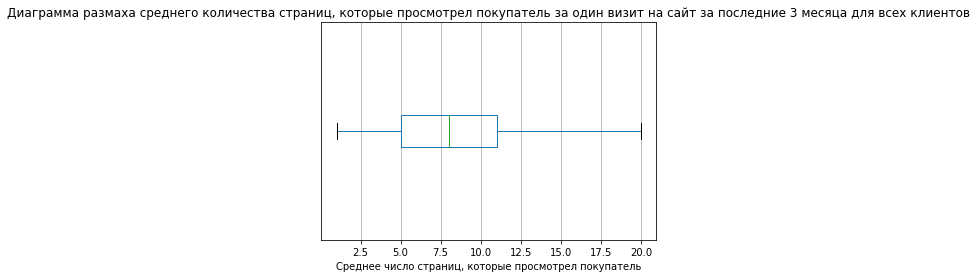

In [116]:
ax = X_test['страниц_за_визит'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Среднее число страниц, которые просмотрел покупатель")
ax.set_title("Диаграмма размаха среднего количества страниц, \
которые просмотрел покупатель за один визит на сайт за последние 3 месяца для всех клиентов");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

In [117]:
print(f'Среднее значение числа страниц, которые просмотрел покупатель \
за один визит на сайт для выбранного сегмента: {customers_tech["страниц_за_визит"].mean():.2f}')
print(f'Медианное значение числа страниц, которые просмотрел покупатель \
за один визит на сайт для выбранного сегмента: {customers_tech["страниц_за_визит"].median():.2f}')
print()
print(f'Среднее значение числа страниц, которые просмотрел покупатель за один визит на сайт для всех клиентов\
: {X_test["страниц_за_визит"].mean():.2f}')
print(f'Медианное значение числа страниц, которые просмотрел покупатель за один визит на сайт для всех клиентов\
: {X_test["страниц_за_визит"].median():.2f}')

Среднее значение числа страниц, которые просмотрел покупатель за один визит на сайт для выбранного сегмента: 4.12
Медианное значение числа страниц, которые просмотрел покупатель за один визит на сайт для выбранного сегмента: 4.00

Среднее значение числа страниц, которые просмотрел покупатель за один визит на сайт для всех клиентов: 8.37
Медианное значение числа страниц, которые просмотрел покупатель за один визит на сайт для всех клиентов: 8.00


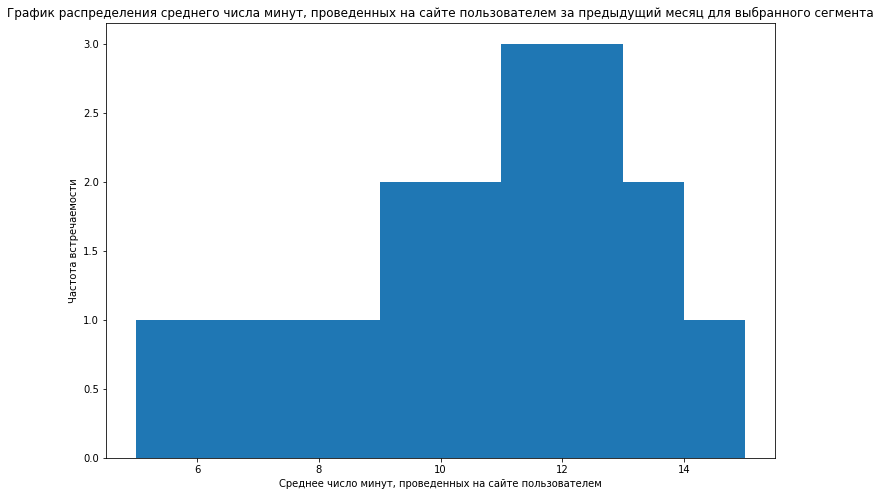

In [118]:
ax = customers_tech['минут_за_предыдущий_месяц'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Среднее число минут, проведенных на сайте пользователем');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднего числа минут, \
проведенных на сайте пользователем за предыдущий месяц для выбранного сегмента");

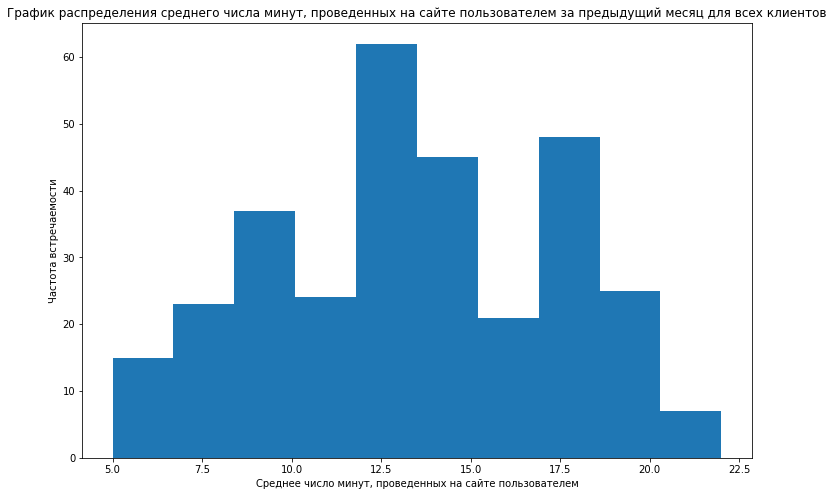

In [119]:
ax = X_test['минут_за_предыдущий_месяц'].plot(kind = 'hist', figsize = (12, 8))
ax.set_xlabel('Среднее число минут, проведенных на сайте пользователем');
ax.set_ylabel('Частота встречаемости');
ax.set_title("График распределения среднего числа минут, \
проведенных на сайте пользователем за предыдущий месяц для всех клиентов");

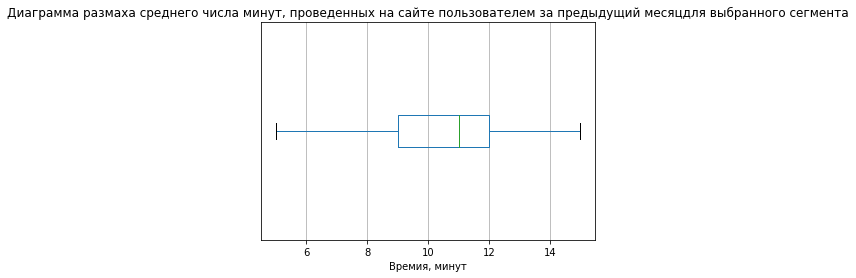

In [120]:
ax = customers_tech['минут_за_предыдущий_месяц'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Времия, минут")
ax.set_title("Диаграмма размаха среднего числа минут, проведенных на сайте пользователем за предыдущий месяц\
для выбранного сегмента");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

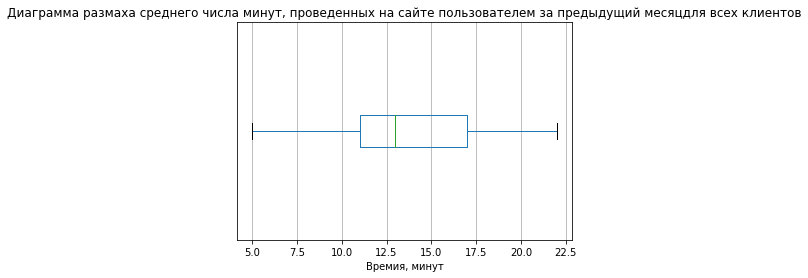

In [121]:
ax = X_test['минут_за_предыдущий_месяц'].plot(kind = "box", grid = True, vert = False)
ax.set_xlabel("Времия, минут")
ax.set_title("Диаграмма размаха среднего числа минут, проведенных на сайте пользователем за предыдущий месяц\
для всех клиентов");
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)

In [122]:
print(f'Среднее значение числа минут,проведенных на сайте пользователем за предыдущий месяц для выбранного сегмента: \
{customers_tech["минут_за_предыдущий_месяц"].mean():.2f}')
print(f'Медианное значение числа минут,проведенных на сайте пользователем за предыдущий месяц для выбранного сегмента: \
{customers_tech["минут_за_предыдущий_месяц"].median():.2f}')
print()
print(f'Среднее значение числа минут,проведенных на сайте за предыдущий месяц для всех клиентов: \
{X_test["минут_за_предыдущий_месяц"].mean():.2f}')
print(f'Медианное значение числа минут,проведенных на сайте за предыдущий месяц для всех клиентов: \
{X_test["минут_за_предыдущий_месяц"].median():.2f}')

Среднее значение числа минут,проведенных на сайте пользователем за предыдущий месяц для выбранного сегмента: 10.24
Медианное значение числа минут,проведенных на сайте пользователем за предыдущий месяц для выбранного сегмента: 11.00

Среднее значение числа минут,проведенных на сайте за предыдущий месяц для всех клиентов: 13.41
Медианное значение числа минут,проведенных на сайте за предыдущий месяц для всех клиентов: 13.00


Видно, что клиенты, покупающие технику и теряющие покупательскую активность, смотрят меньше категорий и вообще страниц на сайте, да и в целом проводят там меньше времени, чем средний покупатель. Таким образом, можно дать следующие рекомендации по увеличению покупательской активности:
- предлагать пользователям больше товаров, похожих на искомый, а также смежных аксессуаров. Это простимулирует посещение новых страниц и увеличит время нахождение на сайте, что должно положительно сказаться на покупательской активности клиентов.

#### Выводы по восьмому этапу
Проведен анализ сегмента пользователей, покупающих технику, то есть товары с длинным жизненным циклом. Даны рекомендации по увеличению покупательской активности данной категории: предлагать пользователям больше товаров, похожих на искомый, а также смежных аксессуаров.

## Общий вывод

Было проведено исследование данных интернет-магазина «В один клик». Сервис предоставил данные о данные о поведении покупателя на сайте, о выручке, которую получает магазин. Цель исследования - разработать модель, которая предскажет вероятность снижения покупательской активности, а также выделить сегмент покупателей, проанализировать его и дать предложения по увеличитению покупательской активности.  
Исследование состояло из следующих этапов и шагов:
- загрузка данных (импортированы необходимые для работы библиотеки; прочитаны и загружены в датафреймы файлы с исходными данными; получена общая информация о данных (столбцы, типы данных));
- предобработка данных (изучены типы данных столбцов; в датафреймах market_file обнаружены и устранены неявные дубликаты);
- исследовательский анализ исходных данных (выявлены самая популярная и не популярная категории товаров для пользователей - это "Товары для детей" и "Кухонная посуда" соответственно; для колирчественных признаков построены графики распределения и рассчитаны средние и медианные значения; установлено, что в среднем за последние три месяца выручка магазина от покупателя растет; в таблицу market_file на основе количественного признака акционные_покупки добавлен новый категорильный признак акционные_покупки_категориальный; выполнен отбор клиентов с покупательской активностью не менее трёх месяцев);
- объединение таблиц (произведено объединение таблиц market_file, market_money, market_time в один датафрейм customer_info с учетом покупательской активности пользователей);
- корреляционный анализ (выявлены признаки, имеющие наибольшее выраженную связь с целевым: количество просмотренных на сайте страниц и время, проведенное на сайте в предыдущем месяце; мультиколлинеарности не обнаружено);
- использование пайплайнов (выполнена подготовка данных для обучения моделей; созданы пайплайны для обучения моделей; выполнен поиск оптимальных параметров. Лучшая модель - на основе метода опорных векторов с линейным ядром и параметром регуляризации С равным 5; метрика модели составлятет 75% на тренировочной выборке и 79% на тестовой);
- анализ важности признаков (выделены признаки, имеющие наибольшее влияние на целевой. Это время, проведенное на сайте, количетво просмотренных товаров и страниц; выделены признаки, имеющие наименьшее влияние на целевой. Это длительность регистрации, тип сервиса, количество сбоев на сайте и увлечение непопулярными категориями; даны рекомендации по сбору дополнительной информации о поведении пользователей на сайте для более точного моделирования бизнес-процессов и принятия решений);
- сегментация покупателей (проведен анализ сегмента пользователей, покупающих технику, то есть товары с длинным жизненным циклом. Даны рекомендации по увеличению покупательской активности данной категории: предлагать пользователям больше товаров, похожих на искомый, а также смежных аксессуаров).